In [1]:
import re
import time
import math
import pandas as pd
import numpy as np
import seaborn as sns
#plt.style.use('seaborn')
from matplotlib import pyplot as plt
%matplotlib inline
from scipy import stats
from scipy.stats.mstats import winsorize
from scipy.stats import boxcox
from matplotlib import pyplot
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import binarize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.decomposition import PCA
from datetime import datetime

# Predicting if an MTA Bus Will Be Late.

## Introduction 

Metropolitan Transportation Authority(MTA) busses in New York city are notorious for being slow and late. For this project we will take a look at a data set from Kaggle and see how accurately we can determine if a bus is going to be late or not. A useful model will be able to be interpreted so that solutions can be developed to improve the bus service performance but we will also be trying to see how accurate wecan get the predictions. 

In [2]:
 # Load data 
#mta = pd.read_csv('C:/Users/keith/Desktop/Thinkful/mta_1706.csv',encoding = "ISO-8859-1",error_bad_lines=False)
mta_bus = pd.read_csv('C:/Users/keith/Desktop/Thinkful/mta_1706_1.csv',encoding = "ISO-8859-1",error_bad_lines=False)
pd.set_option('display.max_columns', 50)

b'Skipping line 53192: expected 17 fields, saw 18\nSkipping line 56712: expected 17 fields, saw 18\nSkipping line 64874: expected 17 fields, saw 18\n'
b'Skipping line 80636: expected 17 fields, saw 18\nSkipping line 97072: expected 17 fields, saw 18\n'
b'Skipping line 107697: expected 17 fields, saw 18\nSkipping line 109317: expected 17 fields, saw 18\nSkipping line 119951: expected 17 fields, saw 18\n'
b'Skipping line 134667: expected 17 fields, saw 18\nSkipping line 139923: expected 17 fields, saw 18\nSkipping line 144309: expected 17 fields, saw 18\nSkipping line 157927: expected 17 fields, saw 18\nSkipping line 158907: expected 17 fields, saw 18\nSkipping line 161424: expected 17 fields, saw 18\n'
b'Skipping line 173221: expected 17 fields, saw 18\nSkipping line 173623: expected 17 fields, saw 18\nSkipping line 177253: expected 17 fields, saw 18\nSkipping line 181883: expected 17 fields, saw 18\nSkipping line 186684: expected 17 fields, saw 18\nSkipping line 191267: expected 17 fie

b'Skipping line 2831078: expected 17 fields, saw 18\nSkipping line 2831884: expected 17 fields, saw 18\nSkipping line 2832778: expected 17 fields, saw 18\n'
b'Skipping line 2935466: expected 17 fields, saw 18\nSkipping line 2937968: expected 17 fields, saw 18\n'
b'Skipping line 2952504: expected 17 fields, saw 18\n'
b'Skipping line 2982958: expected 17 fields, saw 18\nSkipping line 2991335: expected 17 fields, saw 18\nSkipping line 3006710: expected 17 fields, saw 18\nSkipping line 3013361: expected 17 fields, saw 18\n'
b'Skipping line 3019557: expected 17 fields, saw 18\nSkipping line 3032671: expected 17 fields, saw 18\n'
b'Skipping line 3068454: expected 17 fields, saw 18\nSkipping line 3079236: expected 17 fields, saw 18\n'
b'Skipping line 3081942: expected 17 fields, saw 18\nSkipping line 3095240: expected 17 fields, saw 18\n'
b'Skipping line 3166450: expected 17 fields, saw 18\nSkipping line 3178126: expected 17 fields, saw 18\n'
b'Skipping line 3192452: expected 17 fields, saw 1

b'Skipping line 5158386: expected 17 fields, saw 18\n'
b'Skipping line 5278636: expected 17 fields, saw 18\n'
b'Skipping line 5389023: expected 17 fields, saw 18\nSkipping line 5393062: expected 17 fields, saw 18\n'
b'Skipping line 5410409: expected 17 fields, saw 18\n'
b'Skipping line 5444054: expected 17 fields, saw 18\n'
b'Skipping line 5496628: expected 17 fields, saw 18\nSkipping line 5496629: expected 17 fields, saw 18\n'
b'Skipping line 5510776: expected 17 fields, saw 18\n'
b'Skipping line 5548626: expected 17 fields, saw 18\nSkipping line 5551773: expected 17 fields, saw 18\nSkipping line 5556312: expected 17 fields, saw 18\nSkipping line 5570453: expected 17 fields, saw 18\n'
b'Skipping line 5577387: expected 17 fields, saw 18\nSkipping line 5580723: expected 17 fields, saw 18\nSkipping line 5582075: expected 17 fields, saw 18\nSkipping line 5596334: expected 17 fields, saw 18\nSkipping line 5602325: expected 17 fields, saw 18\n'
b'Skipping line 5606005: expected 17 fields, s

In [3]:
#take sample because the full set is too much to try to analyze on local machine
mta = mta_bus.sample(n=20000,random_state=20)

# Data Description

In [4]:
mta.head()

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,VehicleLocation.Latitude,VehicleLocation.Longitude,NextStopPointName,ArrivalProximityText,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime
249431,2017-06-02 00:05:00,1,Q17,138 ST/37 AV,40.761806,-73.829559,JAMAICA ARCHER AV,40.704933,-73.793320,NYCT_8442,40.712529,-73.784314,HILLSIDE AV/EDGERTON BL,approaching,128.0,NaN,23:58:34
5083624,2017-06-23 16:20:48,0,B44-SBS,KNAPP ST/SHORE PKY,40.585033,-73.931328,SBS WLMSBRG BRDG PLZ via NSTRND via RGRS,40.709316,-73.959587,NYCT_5357,40.603164,-73.942410,NOSTRAND AV/KINGS HY,0.9 miles away,1427.0,2017-06-23 16:26:00,16:26:16
2001707,2017-06-09 17:38:05,1,Bx9,NaN,NaN,NaN,WEST FARMS,40.840641,-73.879807,NYCT_1214,40.879992,-73.904038,BROADWAY/W 231 ST,approaching,120.0,2017-06-09 17:39:19,NaN
2315680,2017-06-11 15:10:33,1,Bx41,WHITE PLAINS RD/E GUN HILL RD,40.877853,-73.866669,THE HUB 150 ST via WEBSTER,40.816887,-73.917488,NYCT_5538,40.819222,-73.916341,MELROSE AV/E 152 ST,< 1 stop away,154.0,2017-06-11 15:11:24,14:59:05
2230060,2017-06-10 22:20:22,1,B1,87 ST/4 Av,40.621925,-74.028496,MANHATTAN BEACH KINGSBORO CC,40.578094,-73.940170,NYCT_7158,40.576590,-73.968469,BRIGHTON BEACH AV/OCEAN PY,approaching,104.0,2017-06-10 22:20:58,22:21:22


In [5]:
 mta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 249431 to 5634610
Data columns (total 17 columns):
RecordedAtTime               20000 non-null object
DirectionRef                 20000 non-null int64
PublishedLineName            20000 non-null object
OriginName                   19821 non-null object
OriginLat                    19821 non-null float64
OriginLong                   19821 non-null float64
DestinationName              20000 non-null object
DestinationLat               19981 non-null float64
DestinationLong              19981 non-null float64
VehicleRef                   20000 non-null object
VehicleLocation.Latitude     20000 non-null float64
VehicleLocation.Longitude    20000 non-null float64
NextStopPointName            19973 non-null object
ArrivalProximityText         19973 non-null object
DistanceFromStop             19973 non-null float64
ExpectedArrivalTime          17362 non-null object
ScheduledArrivalTime         19505 non-null object
dtypes: flo

In [6]:
mta.shape

(20000, 17)

# Data cleaning

In [7]:
mta.duplicated().sum()

0

In [8]:
#pd.set_option('display.max_columns', None) # disables trucated columns 
#pd.set_option('display.max_rows', None) # disables trucated rows
mta.head()   

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,VehicleLocation.Latitude,VehicleLocation.Longitude,NextStopPointName,ArrivalProximityText,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime
249431,2017-06-02 00:05:00,1,Q17,138 ST/37 AV,40.761806,-73.829559,JAMAICA ARCHER AV,40.704933,-73.793320,NYCT_8442,40.712529,-73.784314,HILLSIDE AV/EDGERTON BL,approaching,128.0,NaN,23:58:34
5083624,2017-06-23 16:20:48,0,B44-SBS,KNAPP ST/SHORE PKY,40.585033,-73.931328,SBS WLMSBRG BRDG PLZ via NSTRND via RGRS,40.709316,-73.959587,NYCT_5357,40.603164,-73.942410,NOSTRAND AV/KINGS HY,0.9 miles away,1427.0,2017-06-23 16:26:00,16:26:16
2001707,2017-06-09 17:38:05,1,Bx9,NaN,NaN,NaN,WEST FARMS,40.840641,-73.879807,NYCT_1214,40.879992,-73.904038,BROADWAY/W 231 ST,approaching,120.0,2017-06-09 17:39:19,NaN
2315680,2017-06-11 15:10:33,1,Bx41,WHITE PLAINS RD/E GUN HILL RD,40.877853,-73.866669,THE HUB 150 ST via WEBSTER,40.816887,-73.917488,NYCT_5538,40.819222,-73.916341,MELROSE AV/E 152 ST,< 1 stop away,154.0,2017-06-11 15:11:24,14:59:05
2230060,2017-06-10 22:20:22,1,B1,87 ST/4 Av,40.621925,-74.028496,MANHATTAN BEACH KINGSBORO CC,40.578094,-73.940170,NYCT_7158,40.576590,-73.968469,BRIGHTON BEACH AV/OCEAN PY,approaching,104.0,2017-06-10 22:20:58,22:21:22


In [9]:
mta.columns

Index(['RecordedAtTime', 'DirectionRef', 'PublishedLineName', 'OriginName',
       'OriginLat', 'OriginLong', 'DestinationName', 'DestinationLat',
       'DestinationLong', 'VehicleRef', 'VehicleLocation.Latitude',
       'VehicleLocation.Longitude', 'NextStopPointName',
       'ArrivalProximityText', 'DistanceFromStop', 'ExpectedArrivalTime',
       'ScheduledArrivalTime'],
      dtype='object')

In [10]:
mta.columns=['RecordedAtTime', 'DirectionRef', 'PublishedLineName', 'OriginName',
       'OriginLat', 'OriginLong', 'DestinationName', 'DestinationLat',
       'DestinationLong', 'VehicleRef', 'VehicleLocation_Lat',
       'VehicleLocation_Long', 'NextStopPointName',
       'ArrivalProximityText', 'DistanceFromStop', 'ExpectedArrivalTime',
       'ScheduledArrivalTime']

In [11]:
mta.isnull().sum()

RecordedAtTime             0
DirectionRef               0
PublishedLineName          0
OriginName               179
OriginLat                179
OriginLong               179
DestinationName            0
DestinationLat            19
DestinationLong           19
VehicleRef                 0
VehicleLocation_Lat        0
VehicleLocation_Long       0
NextStopPointName         27
ArrivalProximityText      27
DistanceFromStop          27
ExpectedArrivalTime     2638
ScheduledArrivalTime     495
dtype: int64

In [12]:
(mta.isnull().sum()/mta.isnull().count()*100).astype(str)+" %"

RecordedAtTime            0.0 %
DirectionRef              0.0 %
PublishedLineName         0.0 %
OriginName              0.895 %
OriginLat               0.895 %
OriginLong              0.895 %
DestinationName           0.0 %
DestinationLat          0.095 %
DestinationLong         0.095 %
VehicleRef                0.0 %
VehicleLocation_Lat       0.0 %
VehicleLocation_Long      0.0 %
NextStopPointName       0.135 %
ArrivalProximityText    0.135 %
DistanceFromStop        0.135 %
ExpectedArrivalTime     13.19 %
ScheduledArrivalTime    2.475 %
dtype: object

We need to drop the rows with missing arrival times. It is usless to us if we can't find the bus is late or not.

In [13]:
mta = mta[mta.ExpectedArrivalTime.isnull()==False]  
mta.isnull().sum()
 

RecordedAtTime            0
DirectionRef              0
PublishedLineName         0
OriginName              151
OriginLat               151
OriginLong              151
DestinationName           0
DestinationLat           11
DestinationLong          11
VehicleRef                0
VehicleLocation_Lat       0
VehicleLocation_Long      0
NextStopPointName         0
ArrivalProximityText      0
DistanceFromStop          0
ExpectedArrivalTime       0
ScheduledArrivalTime    151
dtype: int64

In [14]:
mta = mta[mta.ScheduledArrivalTime.isnull()==False]
mta.isnull().sum()

RecordedAtTime          0
DirectionRef            0
PublishedLineName       0
OriginName              0
OriginLat               0
OriginLong              0
DestinationName         0
DestinationLat          0
DestinationLong         0
VehicleRef              0
VehicleLocation_Lat     0
VehicleLocation_Long    0
NextStopPointName       0
ArrivalProximityText    0
DistanceFromStop        0
ExpectedArrivalTime     0
ScheduledArrivalTime    0
dtype: int64

In [15]:
len(mta)/200000

0.086055

In [16]:
# reindex dataset
mta.index = range(len(mta.index))

That took care of all of our null values, that we can tell anyway.

Next we need to create a target variable. We are trying to predict if a bus is going to be late or not so we will convert the time rows in to manageable data and the find the difference in times.

In [17]:
# modifying "ScheduledArrivalTime" format to match "EstimatedArrivalTime"
mta.loc[list(np.where(mta.ScheduledArrivalTime=='24:00:00')[0]),'ScheduledArrivalTime'] = '00:00:01'
mta['ScheduledArrivalTime'] = pd.to_timedelta(mta.ScheduledArrivalTime)
mta['ScheduledArrivalTime'] = pd.to_timedelta(mta.ScheduledArrivalTime)
mta['ScheduledArrivalTime'] = pd.to_datetime(mta.ScheduledArrivalTime)

# converting "ExpectedArrivalTime" to datetime format and them finding the diffence between ScheduledArrivalTime
# "ExpectedArrivalTime"
mta['ExpectedArrivalTime'] = pd.to_datetime(mta.ExpectedArrivalTime)
mta['ScheduledArrivalTime'] = mta.ExpectedArrivalTime.dt.date.astype('str') +' '+ mta.ScheduledArrivalTime.dt.time.astype('str')
mta['ScheduledArrivalTime'] = pd.to_datetime(mta.ScheduledArrivalTime)
mta['ScheduledArrivalTime'] = pd.to_datetime(mta.ScheduledArrivalTime)
index = mta[(mta.ScheduledArrivalTime.dt.hour==23) & (mta.ExpectedArrivalTime.dt.hour==00)].index
mta.loc[index,'ScheduledArrivalTime'] = mta.ScheduledArrivalTime + pd.DateOffset(days=-1)

# Finally creating a binary target "Late_bus"
mta.loc[list(np.where(mta.ExpectedArrivalTime>mta.ScheduledArrivalTime)[0]),'Time_delay'] = pd.to_datetime(mta.ExpectedArrivalTime -  mta.ScheduledArrivalTime).dt.minute 
mta.loc[list(np.where(mta.ExpectedArrivalTime<mta.ScheduledArrivalTime)[0]),'Time_delay'] = pd.to_datetime(mta.ScheduledArrivalTime - mta.ExpectedArrivalTime ).dt.minute*-1
mta.loc[list(np.where(mta.Time_delay.isna()==True)[0]),'Time_delay'] = 0

mta['Late_Bus'] = np.where(mta.Time_delay>7, 1, 0)

In [18]:
# checking to make sure that time is only in the month of June
mta.ScheduledArrivalTime.dt.month.unique()

array([6], dtype=int64)

In [19]:
mta.drop(list(np.where(mta.ScheduledArrivalTime.dt.month==5)[0]),axis='index',inplace=True)
# reindex dataset
mta.index = range(len(mta.index))
mta.ScheduledArrivalTime.dt.month.unique()

array([6], dtype=int64)

In [20]:
# test to see if it worked from a sample
mta.sample(frac=.001).head()

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,VehicleLocation_Lat,VehicleLocation_Long,NextStopPointName,ArrivalProximityText,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime,Time_delay,Late_Bus
8884,2017-06-01 07:24:22,0,B17,E 80 ST/PAERDEGAT 15 ST,40.627884,-73.900543,CROWN HTS EASTERN PKY,40.668556,-73.931625,NYCT_6829,40.641208,-73.907061,REMSEN AV/GLENWOOD RD,approaching,116.0,2017-06-01 07:24:56,2017-06-01 07:26:00,-1.0,0
3649,2017-06-30 13:12:47,1,M1,MALCOLM X BL/W 146 ST,40.821056,-73.935829,E VILLAGE 8 ST via 5 AV,40.730282,-73.990532,NYCT_3888,40.787558,-73.956021,5 AV/EAST 94 ST,approaching,131.0,2017-06-30 13:13:28,2017-06-30 12:58:51,14.0,1
15940,2017-06-02 17:36:40,1,Bx6,FOOD CENTER DR/MARKET ST,40.810043,-73.876694,RIVERSIDE DR,40.836205,-73.948479,NYCT_690,40.824911,-73.916339,E 161 ST/PARK AV,approaching,55.0,2017-06-02 17:37:11,2017-06-02 17:31:06,6.0,0
12348,2017-06-24 06:31:25,0,Q44-SBS,MERRICK BL/ARCHER AV,40.704906,-73.793304,SELECT BUS BRONX ZOO via MAIN ST,40.842457,-73.877121,NYCT_5917,40.840092,-73.877327,E 180 ST/DEVOE AV,< 1 stop away,339.0,2017-06-24 06:32:47,2017-06-24 06:35:00,-2.0,0
906,2017-06-09 08:27:01,1,M86-SBS,E 92 ST/YORK AV,40.779755,-73.944534,Select Bus Service Westside West End AV,40.788155,-73.976067,NYCT_5839,40.788106,-73.976012,W 86 ST/BROADWAY,at stop,6.0,2017-06-09 08:27:34,2017-06-09 08:20:00,7.0,0


The conversion worked. We created a feature 'Time_delay' where the values are the minutes of delay ot the bus. Values that are greater than zero are the number of minutes past the scheduled arrival time. The values that are less that zero are the number of minutes the bus arrived ahead of schedule.

The 'Late_Bus' feature is labels a '1' for a bus who's arrival time is greater than 15 min past the scheduled arrival time and labels a '0' for anything under that time. This is our target

In [21]:
mta.head()

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,VehicleLocation_Lat,VehicleLocation_Long,NextStopPointName,ArrivalProximityText,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime,Time_delay,Late_Bus
0,2017-06-23 16:20:48,0,B44-SBS,KNAPP ST/SHORE PKY,40.585033,-73.931328,SBS WLMSBRG BRDG PLZ via NSTRND via RGRS,40.709316,-73.959587,NYCT_5357,40.603164,-73.942410,NOSTRAND AV/KINGS HY,0.9 miles away,1427.0,2017-06-23 16:26:00,2017-06-23 16:26:16,0.0,0
1,2017-06-11 15:10:33,1,Bx41,WHITE PLAINS RD/E GUN HILL RD,40.877853,-73.866669,THE HUB 150 ST via WEBSTER,40.816887,-73.917488,NYCT_5538,40.819222,-73.916341,MELROSE AV/E 152 ST,< 1 stop away,154.0,2017-06-11 15:11:24,2017-06-11 14:59:05,12.0,1
2,2017-06-10 22:20:22,1,B1,87 ST/4 Av,40.621925,-74.028496,MANHATTAN BEACH KINGSBORO CC,40.578094,-73.940170,NYCT_7158,40.576590,-73.968469,BRIGHTON BEACH AV/OCEAN PY,approaching,104.0,2017-06-10 22:20:58,2017-06-10 22:21:22,0.0,0
3,2017-06-14 10:06:11,1,B62,JACKSON AV/QUEENS PZ S,40.748638,-73.938446,DOWNTOWN BKLYN FULTON MALL,40.690407,-73.989471,NYCT_4519,40.712838,-73.960482,DRIGGS AV/S 2 ST,approaching,49.0,2017-06-14 10:06:27,2017-06-14 09:59:15,7.0,0
4,2017-06-28 17:09:54,1,Q76,132 ST/20 AV,40.782063,-73.836716,JAMAICA 165 ST TERM via F LEWIS,40.707615,-73.795540,NYCT_4195,40.715189,-73.773367,HILLSIDE AV/188 ST,at stop,8.0,2017-06-28 17:10:08,2017-06-28 17:03:28,6.0,0


In [22]:
mta.Late_Bus.value_counts()

0    12626
1     4585
Name: Late_Bus, dtype: int64

    Next, "ArrivalProximityText" and "DistanceFromStop" are redundant variables so one can be dropped.

In [23]:
mta.drop("ArrivalProximityText",1,inplace=True)

In [24]:
# convert the categorical variables to the correct data type
columns = ['DirectionRef','PublishedLineName','OriginName',
           'DestinationName','VehicleRef','NextStopPointName']
for col in columns:
    mta[col] = mta[col].astype('category')
    
mta['RecordedAtTime'] = pd.to_datetime(mta.RecordedAtTime)

In [25]:
# breaking up "ScheduledArrivalTime" into components
mta['day'] = pd.to_numeric(mta.ScheduledArrivalTime.dt.day)
mta['hour'] = pd.to_numeric(mta.ScheduledArrivalTime.dt.hour)
mta['minute'] = pd.to_numeric(mta.ScheduledArrivalTime.dt.minute)
mta['weekday'] = mta.ScheduledArrivalTime.dt.day_name().astype('category')
mta['day_of_week'] = pd.to_numeric(mta.ScheduledArrivalTime.dt.weekday)

In [26]:
# sort dataframe by Scheduled arrival time
mta.index = mta.ScheduledArrivalTime
mta = mta.sort_index()
mta.index = range(len(mta))

In [27]:
mta.head()

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,VehicleLocation_Lat,VehicleLocation_Long,NextStopPointName,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime,Time_delay,Late_Bus,day,hour,minute,weekday,day_of_week
0,2017-06-01 00:03:30,1,X17,E 57 ST/3 AV,40.760429,-73.967674,ARDEN HTS HUGENOT AV via NJ via DRMGOOLE,40.543644,-74.196716,NYCT_2725,40.563053,-74.175912,ARTHUR KILL RD/ANNADALE RD,157.0,2017-06-01 00:03:56,2017-06-01 00:01:32,2.0,0,1,0,1,Thursday,3
1,2017-06-01 00:13:31,0,Q30,ARCHER AV /SUTPHIN BL,40.700489,-73.807884,LITTLE NECK L NECK PKY,40.764297,-73.725914,NYCT_8443,40.764774,-73.725227,NASSAU BL/LITTLE NECK PY,77.0,2017-06-01 00:13:57,2017-06-01 00:02:00,11.0,1,1,0,2,Thursday,3
2,2017-06-01 00:03:40,1,Bx36,RANDALL AV/OLMSTEAD AV,40.818676,-73.851555,WASHINGTON HTS GW BRIDGE,40.849033,-73.937309,NYCT_281,40.822321,-73.855112,LAFAYETTE AV/PUGSLEY AV,29.0,2017-06-01 00:03:56,2017-06-01 00:02:51,1.0,0,1,0,2,Thursday,3
3,2017-06-01 00:13:47,0,Q17,MERRICK BL/ARCHER AV,40.704906,-73.793304,FLUSHING MAIN ST STA,40.761745,-73.829529,NYCT_8417,40.740906,-73.787620,HORACE HARDING EXP/185 ST,162.0,2017-06-01 00:14:07,2017-06-01 00:09:53,4.0,0,1,0,9,Thursday,3
4,2017-06-01 00:13:38,0,B38,TILLARY ST/CADMAN PZ E,40.696106,-73.990364,RIDGEWOOD METRO AV,40.713341,-73.914688,NYCT_7228,40.687247,-73.976757,FULTON ST/LAFAYETTE AV,10.0,2017-06-01 00:13:57,2017-06-01 00:14:50,0.0,0,1,0,14,Thursday,3


# Exploratory Data Analysis

In [28]:
mta.columns

Index(['RecordedAtTime', 'DirectionRef', 'PublishedLineName', 'OriginName',
       'OriginLat', 'OriginLong', 'DestinationName', 'DestinationLat',
       'DestinationLong', 'VehicleRef', 'VehicleLocation_Lat',
       'VehicleLocation_Long', 'NextStopPointName', 'DistanceFromStop',
       'ExpectedArrivalTime', 'ScheduledArrivalTime', 'Time_delay', 'Late_Bus',
       'day', 'hour', 'minute', 'weekday', 'day_of_week'],
      dtype='object')

In [29]:
mta.describe()

,OriginLat,OriginLong,DestinationLat,DestinationLong,VehicleLocation_Lat,VehicleLocation_Long,DistanceFromStop,Time_delay,Late_Bus,day,hour,minute,day_of_week
count,17211.000000,17211.000000,17211.000000,17211.000000,17211.000000,17211.000000,17211.000000,17211.000000,17211.000000,17211.000000,17211.000000,17211.000000,17211.000000
mean,40.729311,-73.931038,40.728702,-73.931645,40.728349,-73.930789,250.279879,5.404451,0.266399,15.470455,13.059264,29.588461,2.763175
std,0.090347,0.093042,0.090573,0.094092,0.086764,0.087809,1079.042462,9.105150,0.442088,8.711509,5.377096,17.308531,1.812326
min,40.506882,-74.246948,40.508106,-74.246948,40.503655,-74.251687,0.000000,-50.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,40.657738,-73.987122,40.657658,-73.989471,40.657721,-73.978969,33.500000,0.000000,0.000000,8.000000,9.000000,15.000000,1.000000
50%,40.715233,-73.932449,40.713356,-73.932266,40.723288,-73.936253,104.000000,3.000000,0.000000,15.000000,13.000000,30.000000,3.000000
75%,40.809174,-73.879936,40.807545,-73.879517,40.803432,-73.883165,214.000000,8.000000,1.000000,23.000000,17.000000,45.000000,4.000000
max,40.912365,-73.701866,40.912376,-73.701385,40.912031,-73.701559,29887.000000,59.000000,1.000000,30.000000,23.000000,59.000000,6.000000


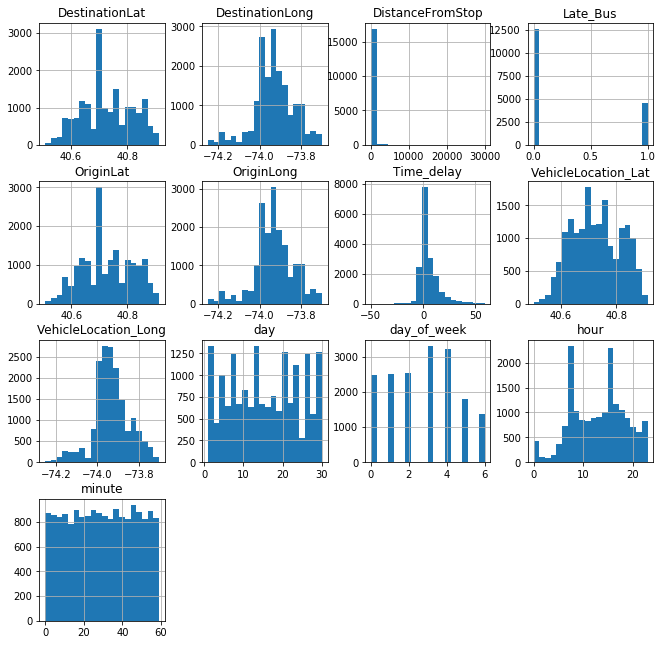

In [30]:
mta.hist(figsize=(11,11),bins=20)
plt.show()

From the histograms of our continuous features we can see that we have a very unbalanced target, which would be expected. There should definetly be more on-time busses that late ones. From here I want to look at the continuous variables for against the target.
 

In [31]:
# Test of the mean distance between stops of late and on-time busses
Late_Bus_dist = mta[mta.Late_Bus==1] 
On_Time_Bus_dist = mta[mta.Late_Bus==0] 
print(stats.ttest_ind(Late_Bus_dist.DistanceFromStop,On_Time_Bus_dist.DistanceFromStop),'\n')

# calculate correlation distance from stop and late busses
print('Correlation of distance from stops and late busses \n',mta.DistanceFromStop.corr(mta.Late_Bus))
print()
print(stats.ttest_ind(Late_Bus_dist.Time_delay,On_Time_Bus_dist.Time_delay),'\n')

 

Ttest_indResult(statistic=2.825369133375402, pvalue=0.0047280538189934255) 

Correlation of distance from stops and late busses 
 0.021532610004554243

Ttest_indResult(statistic=156.51492682118848, pvalue=0.0) 



There is a statistically significant difference in the average distance from stop of Late busses and on-time busses. There is also a positive correlation between distance from stop and late busses.

In [32]:
mta[['Time_delay','DistanceFromStop']].describe()

,Time_delay,DistanceFromStop
count,17211.000000,17211.000000
mean,5.404451,250.279879
std,9.105150,1079.042462
min,-50.000000,0.000000
25%,0.000000,33.500000
50%,3.000000,104.000000
75%,8.000000,214.000000
max,59.000000,29887.000000


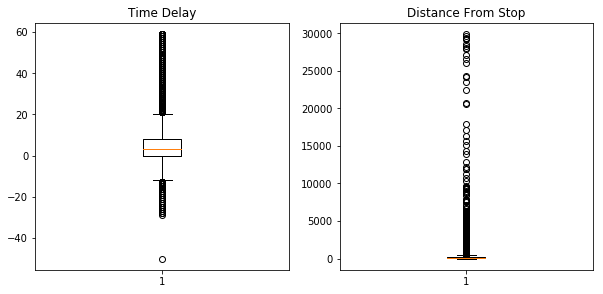

In [33]:
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.boxplot(mta.Time_delay)
plt.title('Time Delay')
plt.subplot(222)
plt.title('Distance From Stop')
plt.boxplot(mta.DistanceFromStop) 
plt.show()

Nothing will be done to correct the outliers in the Time Delay variable. We used this to create out target variable and it will not be used in any models. As far a the distance from stop variable we can look at winzorizing to minimize the outliers.

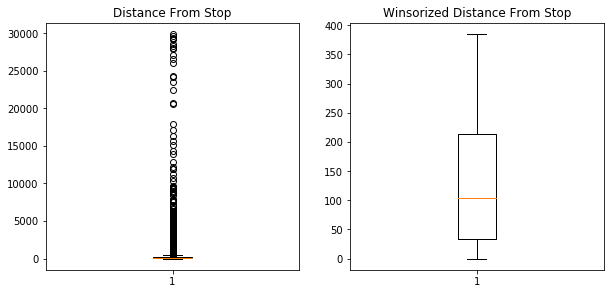

In [34]:
winsor_dist = winsorize(mta["DistanceFromStop"], (0, .1)) # one way wizorization of distance from stop 
#                                                           variable with limit set at the 90th percentile

plt.figure(figsize=(10,10))
plt.title('Distance From Stop') 
plt.subplot(221)
plt.title('Distance From Stop')
plt.boxplot(mta.DistanceFromStop) 


plt.subplot(222)
plt.title('Winsorized Distance From Stop')
plt.boxplot(winsor_dist)
plt.show()

In [35]:
# create a feature for winsorization of the distance from stops
mta['winsor_dist'] = winsor_dist 

In [36]:
mta.sample(frac=.1)[:10]

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,VehicleLocation_Lat,VehicleLocation_Long,NextStopPointName,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime,Time_delay,Late_Bus,day,hour,minute,weekday,day_of_week,winsor_dist
2146,2017-06-05 00:20:18,0,Q17,MERRICK BL/ARCHER AV,40.704906,-73.793304,FLUSHING MAIN ST STA,40.761745,-73.829529,NYCT_8434,40.761041,-73.829321,138 ST/37 AV,79.0,2017-06-05 00:20:44,2017-06-05 00:18:00,2.0,0,5,0,18,Monday,0,79.0
3092,2017-06-06 13:13:06,1,Q31,FRANCIS LEWIS BL/27 AV,40.772629,-73.795067,JAMAICA LIRR STA SUTPHIN BL,40.700500,-73.807838,NYCT_4206,40.769616,-73.789619,32 AV/200 ST,17.0,2017-06-06 13:13:31,2017-06-06 13:13:10,0.0,0,6,13,13,Tuesday,1,17.0
14071,2017-06-25 18:54:15,0,B82,HARWAY AV/BAY 37 ST,40.593510,-73.993996,SPRING CRK TWRS SEAVIEW AV via KINGS HWY,40.642990,-73.878326,NYCT_6832,40.608681,-73.958437,KINGS HY/EAST 16 ST,87.0,2017-06-25 18:54:44,2017-06-25 18:19:32,35.0,1,25,18,19,Sunday,6,87.0
7792,2017-06-14 13:46:07,0,Bx13,W 178 ST/FT WASHINGTON AV,40.848492,-73.938560,RIVER AV - 149 ST,40.819691,-73.930046,NYCT_8364,40.848241,-73.931172,W 181 ST/AMSTERDAM AV,3.0,2017-06-14 13:46:39,2017-06-14 13:37:53,8.0,1,14,13,37,Wednesday,2,3.0
10595,2017-06-19 16:44:02,0,Bx26,W 205 ST/PAUL AV,40.876999,-73.889854,CO-OP CITY EARHART LA via ALLERTN,40.860828,-73.822670,NYCT_8341,40.868105,-73.884320,BEDFORD PK BL/WEBSTER AV,154.0,2017-06-19 16:45:10,2017-06-19 16:43:00,2.0,0,19,16,43,Monday,0,154.0
13918,2017-06-25 09:13:16,0,B3,25 AV/HARWAY AV,40.593021,-73.992180,BERGEN BCH E 71 ST via AV U,40.619881,-73.907265,NYCT_4855,40.619650,-73.907730,AV U/E 71 ST,46.0,2017-06-25 09:13:47,2017-06-25 09:02:00,11.0,1,25,9,2,Sunday,6,46.0
7249,2017-06-13 17:04:52,0,Bx11,W 179 ST/BROADWAY,40.849113,-73.937752,W FARMS RD SOUTHERN BL,40.825272,-73.891426,NYCT_7765,40.839391,-73.904209,CLAREMONT PKY/WASHINGTON AV,181.0,2017-06-13 17:06:40,2017-06-13 16:55:47,10.0,1,13,16,55,Tuesday,1,181.0
13867,2017-06-25 00:52:44,1,B54,PALMETTO ST/ST NICHOLAS AV,40.700420,-73.910233,DNTWN BKLYN JAY ST via MYRTLE,40.694489,-73.987122,NYCT_7289,40.693547,-73.980705,MYRTLE AV/PRINCE ST,169.0,2017-06-25 00:53:32,2017-06-25 00:41:45,11.0,1,25,0,41,Sunday,6,169.0
6620,2017-06-12 17:23:08,0,M7,AV OF THE AMERICAS/W 14 ST,40.737930,-73.996346,HARLEM 147 ST via 6 AV via AMSTERDAM,40.821110,-73.935898,NYCT_6781,40.757030,-73.982519,AV OF THE AMERICAS/W 45 ST,5.0,2017-06-12 17:23:24,2017-06-12 17:09:04,14.0,1,12,17,9,Monday,0,5.0
17130,2017-06-30 19:33:21,1,B6,LIVONIA AV/ASHFORD ST,40.666382,-73.883614,LTD BENSONHURST HARWAY AV,40.592949,-73.993385,NYCT_7165,40.640413,-73.905694,FLATLANDS AV/REMSEN AV,15.0,2017-06-30 19:33:56,2017-06-30 19:29:39,4.0,0,30,19,29,Friday,4,15.0


# Categorical Variables

In [37]:
mta[['PublishedLineName', 'OriginName','DestinationName','VehicleRef','NextStopPointName']].describe()

,PublishedLineName,OriginName,DestinationName,VehicleRef,NextStopPointName
count,17211,17211,17211,17211,17211
unique,236,475,561,4172,5873
top,B6,E 126 ST/2 AV,WASHINGTON HTS GW BRIDGE,NYCT_4242,138 ST/37 AV
freq,325,295,225,14,38


# Late Busses and Time Delays by hour


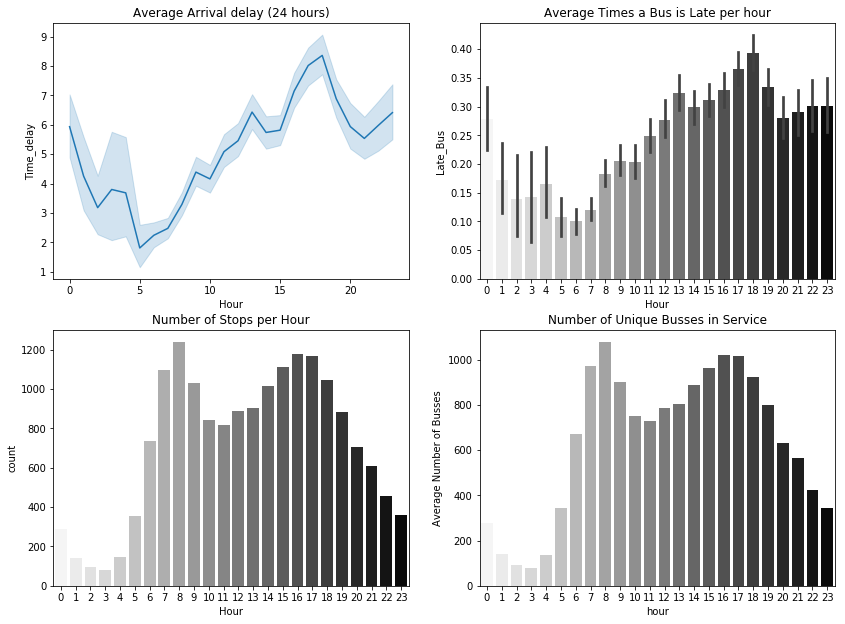

In [38]:
plt.figure(figsize=(14,16))
plt.subplot(321)
sns.lineplot(x= mta.ScheduledArrivalTime.dt.hour, 
             y=mta.Time_delay, data=mta,)
plt.title('Average Arrival delay (24 hours)') 
plt.xlabel('Hour')

plt.subplot(322)
sns.barplot(mta.ScheduledArrivalTime.dt.hour,mta[mta.DistanceFromStop<500].Late_Bus,palette= "gist_gray_r")
plt.title('Average Times a Bus is Late per hour')
plt.xlabel('Hour')

plt.subplot(323)
sns.countplot(mta.ScheduledArrivalTime.dt.hour, palette= "gist_gray_r")
plt.title('Number of Stops per Hour') 
plt.xlabel('Hour')

plt.subplot(324)
hour_df = pd.DataFrame(mta.groupby('hour').VehicleRef.unique())
hour_df = pd.DataFrame(hour_df.VehicleRef.apply(lambda x : len(x)))
plt.title('Number of Unique Busses in Service')
plt.xlabel('Hour')
plt.ylabel('Busses in Service')
hour_df['hour'] = hour_df.index
hour_df.index = range(len(hour_df))
sns.barplot(hour_df.hour, hour_df.VehicleRef, palette= "gist_gray_r")
plt.ylabel('Average Number of Busses')

plt.show()

After 6a.m. then average number of late busses steadily increases and peaks at 6p.m. It then flattens and falls between the hours of 1a.m. and 6a.m. This could be because there is less traffic at this time. 

In [39]:
index = mta[(mta.ScheduledArrivalTime.dt.hour>=8) & (mta.ScheduledArrivalTime.dt.hour<=19)].index  
mta['increased_Late'] = 0
mta.loc[index,'increased_Late'] = 1


In [40]:
mta.increased_Late.value_counts()

1    12135
0     5076
Name: increased_Late, dtype: int64

Here I am going to bin hours in to groups to form a feature that represents afternoon evening and night to caprture the differences in late busses during those times. 

In [41]:
# create time of day feature
bins=[-1, 5, 11, 16, 20, 23]
bin_names = ['night','morning','afternoon','evening','Night']
mta['time_of_day'] = pd.cut(mta.ScheduledArrivalTime.dt.hour, bins,labels=bin_names)
mta['time_of_day'] = mta['time_of_day'].str.lower().astype('category')

In [42]:
(mta.groupby(mta.time_of_day).Late_Bus.mean().sort_index(ascending=False)*100).astype(str)+" %"

time_of_day
night        24.290220820189273 %
morning      17.845993756503642 %
evening       35.59055118110236 %
afternoon    31.064914689154737 %
Name: Late_Bus, dtype: object

Afternoon and evening look to have the greatest average of late busses. Before looking I would have expected morning and evening to have the worse of the problem because of traffic at those times. Lets do a ttest to confirm that there is significant differences in the average number of late busses between each time of day.

In [43]:
# t-test between the means of the percentage of late busses of the hours in the day
tod_pvalues = {}
for i in range(len(mta.time_of_day.unique())):
        for j in range(i+1,4):
            print(mta.time_of_day.unique()[i],' vs ',mta.time_of_day
                  .unique()[j]) 
            print(stats.ttest_ind(
                mta[mta.time_of_day==mta.time_of_day.unique()[i]]['Late_Bus'], 
                mta[mta.time_of_day==mta.time_of_day.unique()[j]]['Late_Bus']))           

night  vs  morning
Ttest_indResult(statistic=6.803103548810826, pvalue=1.0948794726131699e-11)
night  vs  afternoon
Ttest_indResult(statistic=-6.170549277951211, pvalue=7.152707063972357e-10)
night  vs  evening
Ttest_indResult(statistic=-9.595013598429581, pvalue=1.1764578652167088e-21)
morning  vs  afternoon
Ttest_indResult(statistic=-16.28312700048901, pvalue=6.467532871917423e-59)
morning  vs  evening
Ttest_indResult(statistic=-20.059144207177372, pvalue=1.0477722609772258e-87)
afternoon  vs  evening
Ttest_indResult(statistic=-4.499029521053928, pvalue=6.912975958539333e-06)


 There looks to be significant diffences between each time of day.

### What percentage of busses are late per hour?


Here is a numerical representation of the graphs above.

In [44]:
(mta.groupby(mta.ScheduledArrivalTime.dt.hour).Late_Bus.mean().sort_index(ascending=False)*100).astype(str)+" %"

ScheduledArrivalTime
23     30.47091412742382 %
22     30.28322440087146 %
21    28.852459016393446 %
20     28.42998585572843 %
19     33.40857787810384 %
18     39.77055449330784 %
17     37.83091374893254 %
16    33.050127442650805 %
15    31.413141314131416 %
14     30.25540275049116 %
13     32.22958057395143 %
12     27.73393461104848 %
11     25.03052503052503 %
10     20.59171597633136 %
9     20.679611650485437 %
8     18.321226795803067 %
7     12.647861692447679 %
6      9.673024523160763 %
5     10.393258426966293 %
4      16.43835616438356 %
3                   15.0 %
2     13.829787234042554 %
1     16.901408450704224 %
0                 28.125 %
Name: Late_Bus, dtype: object

# Late Busses and Time Delays by day of the Week

In [45]:
print('Description of Late Busses Delays by Weekday')
weekday_order={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
Late_bus_mean = mta[mta.Time_delay>=0].groupby(mta.ScheduledArrivalTime.dt.weekday).Late_Bus.describe()
Late_bus_mean.index = weekday_order.values()
Late_bus_mean

Description of Late Busses Delays by Weekday


,count,mean,std,min,25%,50%,75%,max
Monday,1983.0,0.254665,0.435782,0.0,0.0,0.0,1.0,1.0
Tuesday,2110.0,0.306161,0.461007,0.0,0.0,0.0,1.0,1.0
Wednesday,2200.0,0.333182,0.471458,0.0,0.0,0.0,1.0,1.0
Thursday,2727.0,0.309498,0.462371,0.0,0.0,0.0,1.0,1.0
Friday,2727.0,0.322332,0.467455,0.0,0.0,0.0,1.0,1.0
Saturday,1539.0,0.365172,0.481635,0.0,0.0,0.0,1.0,1.0
Sunday,1189.0,0.349874,0.477131,0.0,0.0,0.0,1.0,1.0


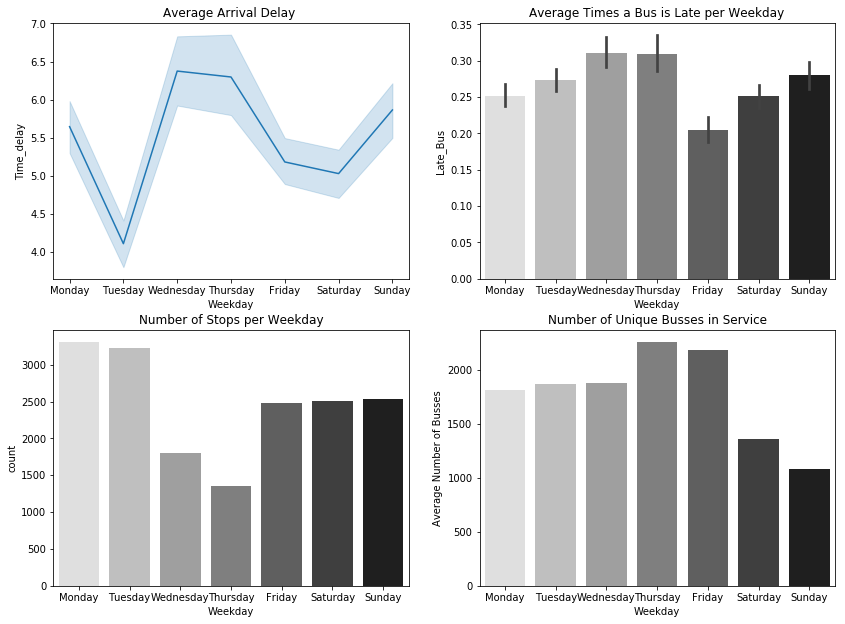

In [46]:
plt.figure(figsize=(14,16))
plt.subplot(321)
sns.lineplot(x= mta.ScheduledArrivalTime.dt.day_name(), 
             y=mta.Time_delay, data=mta)
plt.xticks(range(0,7), weekday_order.values())
plt.title('Average Arrival Delay ') 
plt.xlabel('Weekday')

plt.subplot(322)
sns.barplot(mta.ScheduledArrivalTime.dt.day_name(),mta[mta.DistanceFromStop<500].Late_Bus, palette= "gist_gray_r")
plt.title('Average Times a Bus is Late per Weekday')
plt.xticks(range(0,7), weekday_order.values())
plt.xlabel('Weekday')

plt.subplot(323)
sns.countplot(mta.ScheduledArrivalTime.dt.day_name(), palette= "gist_gray_r")
plt.xticks(range(0,7), weekday_order.values())
plt.title('Number of Stops per Weekday') 
plt.xlabel('Weekday')

plt.subplot(324)
day_df = pd.DataFrame(mta.groupby('day_of_week').VehicleRef.unique())
day_df = pd.DataFrame(day_df.VehicleRef.apply(lambda x : len(x)))
plt.title('Number of Unique Busses in Service')
plt.xlabel('Weekday')
plt.ylabel('Busses in Service')
day_df['Weekday'] = day_df.index
day_df.index = range(len(day_df))
sns.barplot(day_df.Weekday, day_df.VehicleRef,palette= "gist_gray_r")
plt.ylabel('Average Number of Busses')
plt.xticks(range(0,7),weekday_order.values())
plt.show()

In [47]:
#ttest between the means of the percentage of late busses of the days of the week
pvales = {}
for i in range(len(mta.ScheduledArrivalTime.dt.weekday.unique())):
        for j in range(i+1,7):
            print(mta.ScheduledArrivalTime.dt.day_name().unique()[i],' vs ',mta.ScheduledArrivalTime.dt.day_name().unique()[j]) 
            print(stats.ttest_ind(
                mta[mta.ScheduledArrivalTime.dt.day_name()==mta.ScheduledArrivalTime.dt.day_name().unique()[i]]['Late_Bus'], 
                mta[mta.ScheduledArrivalTime.dt.day_name()==mta.ScheduledArrivalTime.dt.day_name().unique()[j]]['Late_Bus']))
            pvales.update({(mta.ScheduledArrivalTime.dt.day_name().unique()[i],' vs ',mta.ScheduledArrivalTime.dt.day_name().unique()[j]):
                          stats.ttest_ind(
                          mta[mta.ScheduledArrivalTime.dt.day_name()==mta.ScheduledArrivalTime.dt.day_name().unique()[i]]['Late_Bus'], 
                          mta[mta.ScheduledArrivalTime.dt.day_name()==mta.ScheduledArrivalTime.dt.day_name().unique()[j]]['Late_Bus'])[1]})

Thursday  vs  Friday
Ttest_indResult(statistic=-1.5602802616953448, pvalue=0.11874211047485317)
Thursday  vs  Saturday
Ttest_indResult(statistic=-4.34573659403194, pvalue=1.4150495286645776e-05)
Thursday  vs  Sunday
Ttest_indResult(statistic=-3.5849661412079454, pvalue=0.00034057390278027897)
Thursday  vs  Monday
Ttest_indResult(statistic=4.58260631092361, pvalue=4.688713274566886e-06)
Thursday  vs  Tuesday
Ttest_indResult(statistic=-0.23281802401703489, pvalue=0.8159109201283206)
Thursday  vs  Wednesday
Ttest_indResult(statistic=-2.8626366536620043, pvalue=0.004216267341610929)
Friday  vs  Saturday
Ttest_indResult(statistic=-2.990733878460198, pvalue=0.0027965755462951015)
Friday  vs  Sunday
Ttest_indResult(statistic=-2.3527135001653203, pvalue=0.018679036289286254)
Friday  vs  Monday
Ttest_indResult(statistic=5.994132688719072, pvalue=2.1710678149255516e-09)
Friday  vs  Tuesday
Ttest_indResult(statistic=1.2166530369272877, pvalue=0.2237863656243663)
Friday  vs  Wednesday
Ttest_indRes

In [48]:
# find all comparisons with pvalues > .05
non_significant = [i for i in pvales if pvales.get(i)>.05]
non_significant

[('Thursday', ' vs ', 'Friday'),
 ('Thursday', ' vs ', 'Tuesday'),
 ('Friday', ' vs ', 'Tuesday'),
 ('Friday', ' vs ', 'Wednesday'),
 ('Saturday', ' vs ', 'Sunday'),
 ('Saturday', ' vs ', 'Wednesday'),
 ('Sunday', ' vs ', 'Wednesday')]

There is no statistcal significance in the average number of late busses between the above days of the week.
Wednesday and Thursday have the greatest average number of late busses. I will make and indicator feature to mark these days. 

In [49]:
# mark Wed and Thurs. as peak late busses
mta['is_midweek'] = 0
mta.loc[list(np.where(mta[(mta.ScheduledArrivalTime.dt.weekday==2)|(mta.ScheduledArrivalTime.dt.weekday==3)])[0]),'is_midweek'] = 1

In [50]:
mta.is_midweek.value_counts()

0    11367
1     5844
Name: is_midweek, dtype: int64

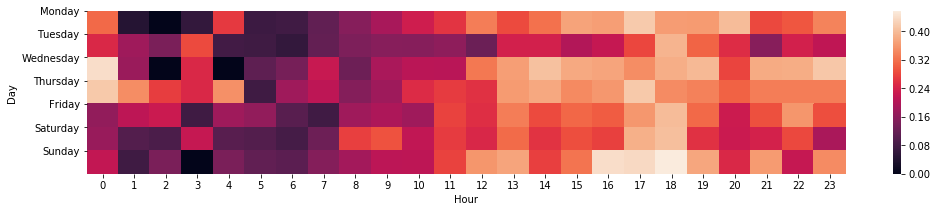

In [51]:
plt.figure(figsize=(17,3))
heat_weekdayhour = mta.pivot_table(index=mta.ScheduledArrivalTime.dt.day_name(), columns=mta.ScheduledArrivalTime.dt.hour, values="Late_Bus")
sns.heatmap(heat_weekdayhour,)
plt.xlabel('Hour')
plt.ylabel('Day')
plt.yticks(np.arange(7),weekday_order.values())
plt.show() 

The heatmap above shows the average late busses of the days of week by hour. There doesnt seem to be any significant difference between the hours that we normally associate with rush hour. it seems that there is just a steady increase of late busses from about 9:30 am up to midnight and then a lull between those times. 

# Late Busses and Time Delays by day of the Month

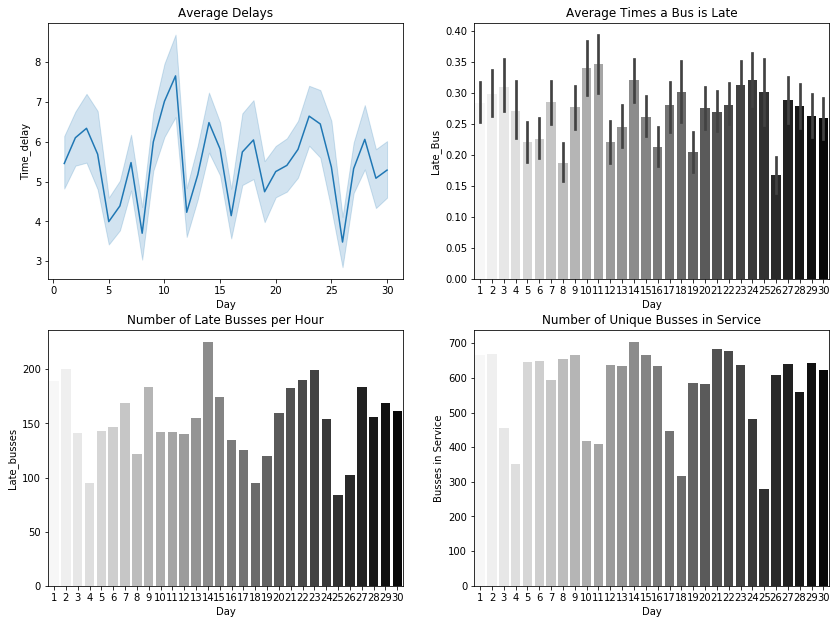

In [52]:
plt.figure(figsize=(14,16))
plt.subplot(321)
sns.lineplot(x= mta.ScheduledArrivalTime.dt.day , 
             y=mta.Time_delay, data=mta,)
plt.xlabel('Day')
plt.title('Average Delays')

plt.subplot(322)
sns.barplot(mta.ScheduledArrivalTime.dt.day,mta.Late_Bus,palette= "gist_gray_r")
plt.xlabel('Day')

plt.title('Average Times a Bus is Late')
 
plt.subplot(323)
sns.countplot(mta[mta.Late_Bus==1].ScheduledArrivalTime.dt.day , palette= "gist_gray_r")
plt.title('Number of Late Busses per Hour')
plt.xlabel('Day')

plt.ylabel('Late_busses')

plt.subplot(324)
#daydf = pd.DataFrame(mta.groupby('day').VehicleRef.unique())
#daydf = pd.DataFrame(daydf.VehicleRef.apply(lambda x : len(x)))
#daydf['day_of_month'] = daydf.index
#daydf.index = range(len(daydf))
#sns.barplot(daydf.day_of_month, daydf.VehicleRef,palette= "gist_gray_r")
sns.countplot(mta.ScheduledArrivalTime.dt.day, palette= "gist_gray_r")
plt.title('Number of Unique Busses in Service')
plt.xlabel('Day')
plt.ylabel('Busses in Service')

plt.show()

The days of the month seem to follow a weekly pattern. With the weekends having the least amount of late busses. The weekends also have fewer busses in service. The number of late busses doesn't seem to be affected by a larger number of busses in service.

In order to capture the cyclical nature of time sin/cos features of hour ,minute, and day of the week will be calculated so that the end of the cycle is show to be close to the beginning instead of far away.

In [53]:
# create sin cos features to capture cyclical nature
mta['sin_min'] = np.sin(mta['minute']*(2*np.pi/60))
mta['cos_min'] = np.cos(mta['minute']*(2*np.pi/60))
mta['sin_hour'] = np.sin(mta['hour']*(2.*np.pi/24))
mta['cos_hour'] = np.cos(mta['hour']*(2.*np.pi/24))
mta['sin_day_of_week'] = np.sin(mta['day_of_week']*(2.*np.pi/7))
mta['cos_day_of_week'] = np.cos(mta['day_of_week']*(2.*np.pi/7))

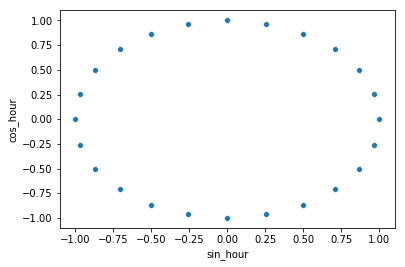

In [54]:
sns.scatterplot(mta.sin_hour,mta.cos_hour)

# Inbound and Outbound Late Busses and Delays

Let's see if there is any difference between the number of late busses of inbound vs outbound busses.

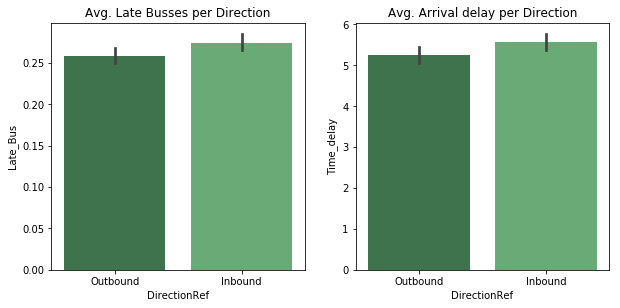

In [55]:
plt.figure(figsize=(10,10))
plt.subplot(221)
sns.barplot(y=mta.Late_Bus,x=mta.DirectionRef,palette="Greens_d",orient='vertical',) 
plt.title('Avg. Late Busses per Direction')
plt.xticks(range(0,2), ['Outbound','Inbound'])

plt.subplot(222)
sns.barplot(y=mta.Time_delay,x=mta.DirectionRef,palette="Greens_d",orient='vertical',) 
plt.title('Avg. Arrival delay per Direction')
plt.xticks(range(0,2), ['Outbound','Inbound'])
plt.show()

The average number of late busses is higher with the inbound busses as well as the average arrival delay.

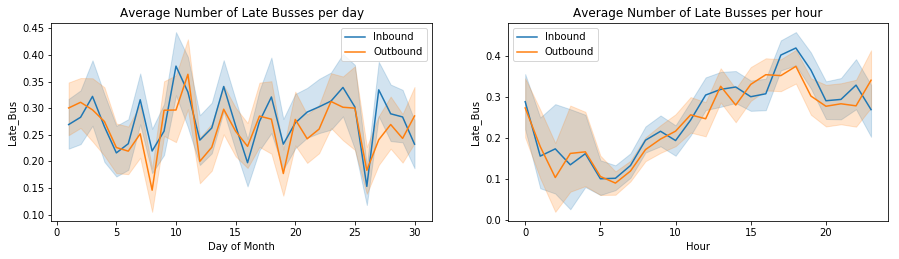

In [56]:
inbound_df = mta[mta.DirectionRef==1]
outbound_df = mta[mta.DirectionRef==0] 
plt.figure(figsize=(15,8))
plt.subplot(221)
sns.lineplot(inbound_df.ScheduledArrivalTime.dt.day.sort_values(), inbound_df.Late_Bus, label='Inbound') 
sns.lineplot(outbound_df.ScheduledArrivalTime.dt.day.sort_values(), outbound_df.Late_Bus, label='Outbound')
plt.title('Average Number of Late Busses per day')
plt.xticks=(np.arange(0,30,.5))
plt.xlabel('Day of Month')
plt.subplot(222)
sns.lineplot(inbound_df.ScheduledArrivalTime.dt.hour.sort_values(), inbound_df.Late_Bus, label='Inbound') 
sns.lineplot(outbound_df.ScheduledArrivalTime.dt.hour.sort_values(), outbound_df.Late_Bus, label='Outbound')
plt.title('Average Number of Late Busses per hour')
plt.xlabel('Hour')
plt.xticks=(np.arange(0,30,.5))
plt.show() 

The inbound and outbound busses show the same pattern over time. With respect hour there are more late inbound busses thoughout most of the day.

In [57]:
# Test of the mean distance between stops of late and on-time busses 
print(stats.ttest_ind(inbound_df.Late_Bus, outbound_df.Late_Bus),'\n')


Ttest_indResult(statistic=2.3700992399332916, pvalue=0.01779427162382705) 



## Distance from stop vs Late Busses 

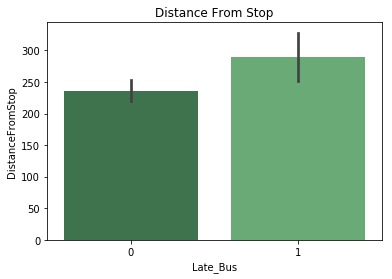

In [58]:
sns.barplot(x='Late_Bus',y='DistanceFromStop', data=mta, palette="Greens_d")
plt.title('Distance From Stop')
#plt.xticks(list(range(0,2)), ['On-Time','Late'])
plt.show()

In [59]:
print('Average distance from stop of on-time and late busses')
mta.groupby('Late_Bus').mean()[['DistanceFromStop']]

Average distance from stop of on-time and late busses


,DistanceFromStop
Late_Bus,
0,236.278869
1,288.835333


In [60]:
onTime_df = mta[mta.Late_Bus==1]
Late_df = mta[mta.Late_Bus==0] 
print('Ttest of average distance between stops of late and on-time Busses:')
print()
print(stats.ttest_ind(onTime_df.DistanceFromStop, Late_df.DistanceFromStop),'\n')

Ttest of average distance between stops of late and on-time Busses:

Ttest_indResult(statistic=2.825369133375402, pvalue=0.0047280538189934255) 



The ttest shows a significant difference between the average distance from a stop and late busses.

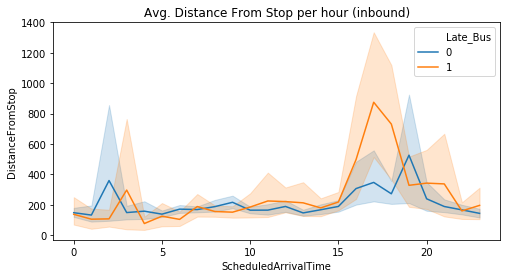

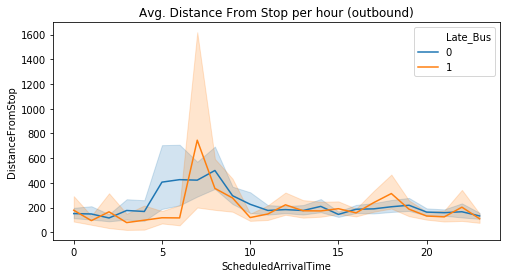

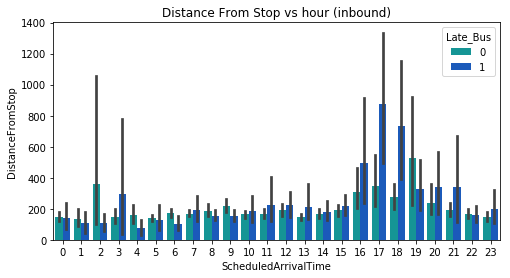

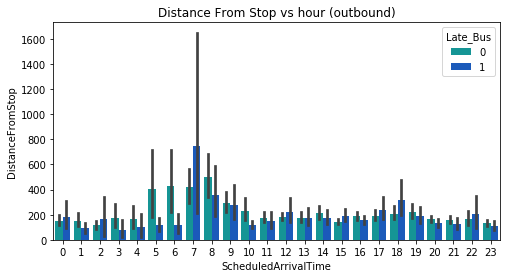

In [61]:
plt.figure(figsize=(8,4))
sns.lineplot(inbound_df.ScheduledArrivalTime.dt.hour.sort_values(), inbound_df.DistanceFromStop, hue=inbound_df.Late_Bus) 
plt.title('Avg. Distance From Stop per hour (inbound)')
plt.show()
plt.figure(figsize=(8,4))

sns.lineplot(outbound_df.ScheduledArrivalTime.dt.hour.sort_values(), outbound_df.DistanceFromStop, hue=outbound_df.Late_Bus)
plt.title('Avg. Distance From Stop per hour (outbound)')
#plt.xticks=(np.arange(0,30,.5))
plt.show() 
plt.figure(figsize=(8,4))
sns.barplot(inbound_df.ScheduledArrivalTime.dt.hour.sort_values(), inbound_df.DistanceFromStop,hue=inbound_df.Late_Bus,palette='winter_r')
plt.title('Distance From Stop vs hour (inbound)')
plt.show()
plt.figure(figsize=(8,4))
sns.barplot(outbound_df.ScheduledArrivalTime.dt.hour.sort_values(), outbound_df.DistanceFromStop,hue=outbound_df.Late_Bus,palette='winter_r')
plt.title('Distance From Stop vs hour (outbound)')
#sns.lineplot(mta.ScheduledArrivalTime.dt.hour.sort_values(), mta.DistanceFromStop, hue=mta.Late_Bus)

plt.show() 

There seems to be a pattern as the day goes on. The distacnce from stops increases for the inbound busses between 3pm and 9pm and for the outbound busses between 5am and 9am. The distance between stops for late busses is father than for the inbound busses than for the outbound. For the outbound busses it seems that distance between stops is greater for the on-time busses. This coincides with New Yorks rush hour. Since the busses are recorded approximately every ten minutes the busses are farther away from their stops for a longer amount of time because of traffic. This could possibly be why this pattern is showing. It doesn't explain the reason the distance between stops is greater for on time busses on the outbound side and the opposite for the inbound. This could be that there are more busses running at that time or that the busses are moving slower but the schedule accounts for those delays making the busses on time. 

I'm goding to create an indicator feature to mark this pattern.

In [62]:
# create rush our indicator feature
mta['rush_hour'] = np.where(np.logical_and(mta.hour>=5, mta.hour<=9) | np.logical_and(mta.hour>=15, mta.hour<=21),1,0)

## Which boroughs have the farthest distance from stop?


The route label prefixes signify the boroughs of New York that the operate in with the exception of routes that begin with "X". The "X" routes are express routes that a operate in all five boroghs and have large distances between stops. Here I will create a feature that groups the published line name(route) in to their areas of operation to condense dimentionality and for analysis.

In [63]:
# create new feature based on the route names and areas of operation based on prefix
def boroughs():
    mta['boroughs'] = '0'
    mta.loc[list(np.where((mta.PublishedLineName.str.contains('x')==False) & (mta.PublishedLineName.str.startswith('B')==True))[0]),'boroughs'] = 'Brooklyn'
    mta.loc[list(np.where(mta.PublishedLineName.str.startswith('Bx')==True)[0]),'boroughs'] = 'Bronx'
    mta.loc[list(np.where(mta.PublishedLineName.str.startswith('Q')==True)[0]),'boroughs'] = 'Queens'
    mta.loc[list(np.where(mta.PublishedLineName.str.startswith('S')==True)[0]),'boroughs'] = 'Staten Island'
    mta.loc[list(np.where(mta.PublishedLineName.str.startswith('M')==True)[0]),'boroughs'] = 'Manhattan'
    mta.loc[list(np.where(mta.PublishedLineName.str.startswith('X')==True)[0]),'boroughs'] = 'X'
    mta['boroughs'] = mta.boroughs.astype('category')
boroughs()


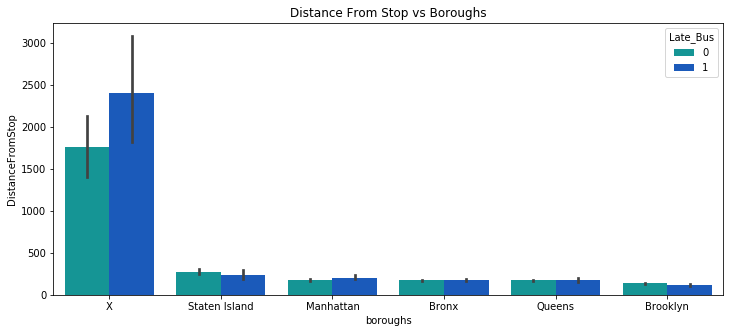

In [64]:
plt.figure(figsize=(12,5)) 
order = mta.groupby('boroughs').DistanceFromStop.mean().sort_values(ascending=False).index
sns.barplot(x='boroughs',y='DistanceFromStop' ,data=mta, hue=mta.Late_Bus,order=order,palette='winter_r')
plt.title('Distance From Stop vs Boroughs')
plt.show()

The "X" routes have the largest average distance from stops. It look like those routes are also resposible for the distance from stops for late busses being greater than the distance from stops for the on-time busses. Let's see what happens when we exclude the "X" routes.

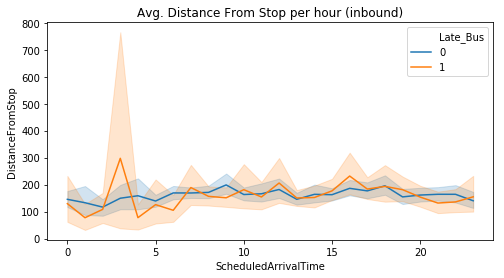

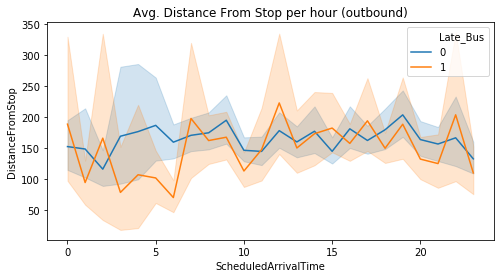

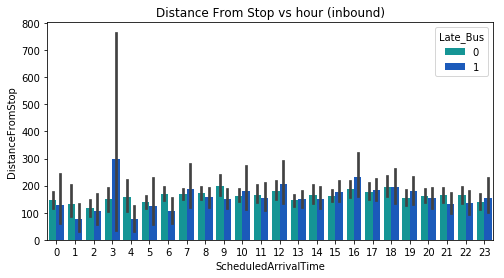

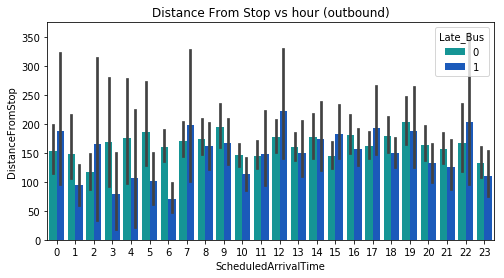

In [65]:
no_x_df = mta[mta.boroughs!='X']
inbound_df = no_x_df[no_x_df.DirectionRef==1]
outbound_df = no_x_df[no_x_df.DirectionRef==0] 

plt.figure(figsize=(8,4))
sns.lineplot(inbound_df.ScheduledArrivalTime.dt.hour.sort_values(), inbound_df.DistanceFromStop, hue=inbound_df.Late_Bus) 
plt.title('Avg. Distance From Stop per hour (inbound)')
plt.show()
plt.figure(figsize=(8,4))

sns.lineplot(outbound_df.ScheduledArrivalTime.dt.hour.sort_values(), outbound_df.DistanceFromStop, hue=outbound_df.Late_Bus)
plt.title('Avg. Distance From Stop per hour (outbound)')
#plt.xticks=(np.arange(0,30,.5))
plt.show() 
plt.figure(figsize=(8,4))
sns.barplot(inbound_df.ScheduledArrivalTime.dt.hour.sort_values(), inbound_df.DistanceFromStop,hue=inbound_df.Late_Bus,palette='winter_r')
plt.title('Distance From Stop vs hour (inbound)')
plt.show()
plt.figure(figsize=(8,4))
sns.barplot(outbound_df.ScheduledArrivalTime.dt.hour.sort_values(), outbound_df.DistanceFromStop,hue=outbound_df.Late_Bus,palette='winter_r')
plt.title('Distance From Stop vs hour (outbound)')
#sns.lineplot(mta.ScheduledArrivalTime.dt.hour.sort_values(), mta.DistanceFromStop, hue=mta.Late_Bus)

plt.show() 

Without the "X" routes the pattern pretty much disappears. This is something to be aware of when modeling because we don't want the algorithm to always focus in on the "X" routes.

In [66]:
#ttest between the means of the percentage of late busses of the days of the week
pvales = {}
for i in range(len(mta.boroughs.unique())):
        for j in range(i+1,6):
            print(mta.boroughs.unique()[i],' vs ',mta.boroughs.unique()[j]) 
            print(stats.ttest_ind(
                mta[mta.boroughs==mta.boroughs.unique()[i]]['Late_Bus'], 
                mta[mta.boroughs==mta.boroughs.unique()[j]]['Late_Bus']))
            pvales.update({(mta.boroughs.unique()[i],' vs ',mta.boroughs.unique()[j]):
                          stats.ttest_ind(
                          mta[mta.boroughs==mta.boroughs.unique()[i]]['Late_Bus'], 
                          mta[mta.boroughs==mta.boroughs.unique()[j]]['Late_Bus'])[1]})

X  vs  Queens
Ttest_indResult(statistic=4.576196356147252, pvalue=4.883213290612644e-06)
X  vs  Bronx
Ttest_indResult(statistic=4.103906882527308, pvalue=4.136919189552055e-05)
X  vs  Brooklyn
Ttest_indResult(statistic=2.4081071759363324, pvalue=0.016065014170120583)
X  vs  Manhattan
Ttest_indResult(statistic=0.9630428863119772, pvalue=0.3355814175889037)
X  vs  Staten Island
Ttest_indResult(statistic=4.580600640223705, pvalue=4.946621035167219e-06)
Queens  vs  Bronx
Ttest_indResult(statistic=-0.8153757537158265, pvalue=0.41488648667328176)
Queens  vs  Brooklyn
Ttest_indResult(statistic=-3.820298350786245, pvalue=0.0001342517650326766)
Queens  vs  Manhattan
Ttest_indResult(statistic=-5.619345523587515, pvalue=1.996197337306114e-08)
Queens  vs  Staten Island
Ttest_indResult(statistic=1.0018126351713634, pvalue=0.316492501868643)
Bronx  vs  Brooklyn
Ttest_indResult(statistic=-3.0751150222331156, pvalue=0.0021106256240832175)
Bronx  vs  Manhattan
Ttest_indResult(statistic=-4.9950563614674

In [67]:
# find all comparisons with pvalues > .05
non_significant = [i for i in pvales if pvales.get(i)>.05]
non_significant

[('X', ' vs ', 'Manhattan'),
 ('Queens', ' vs ', 'Bronx'),
 ('Queens', ' vs ', 'Staten Island'),
 ('Bronx', ' vs ', 'Staten Island')]

## Compare boroughs to late busses

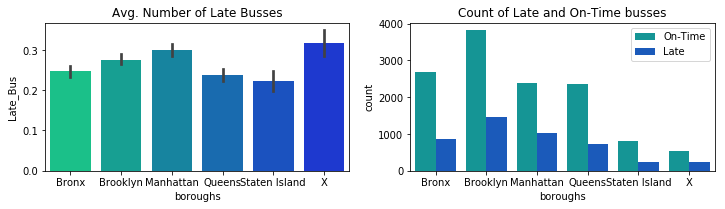

In [68]:
plt.figure(figsize=(12,6)) 
plt.subplot(221)
sns.barplot(x='boroughs',y='Late_Bus' ,data=mta,  palette='winter_r' )
plt.title('Avg. Number of Late Busses')

plt.subplot(222)
sns.countplot(x='boroughs',hue='Late_Bus' ,data=mta,  palette='winter_r' )
plt.legend(['On-Time','Late'])
plt.title('Count of Late and On-Time busses')
plt.show()

In [69]:
# chi-square test to test significance of group size
borough_count_table = pd.crosstab(mta.Late_Bus,mta.boroughs)
print('Chi-square Test Results significance of group size of boroughs')
print(stats.chisquare(borough_count_table, axis=None))


Chi-square Test Results significance of group size of boroughs
Power_divergenceResult(statistic=9816.609552030679, pvalue=0.0)


In [70]:
mta.groupby('boroughs').Late_Bus.agg(['mean','count'])

,mean,count
boroughs,,
Bronx,0.246552,3553
Brooklyn,0.275934,5302
Manhattan,0.299766,3416
Queens,0.237957,3093
Staten Island,0.222852,1059
X,0.317259,788


Although the "X" routes are represented the least in the dataset they have the highest agverage of late busses. 

#  Geospacial features

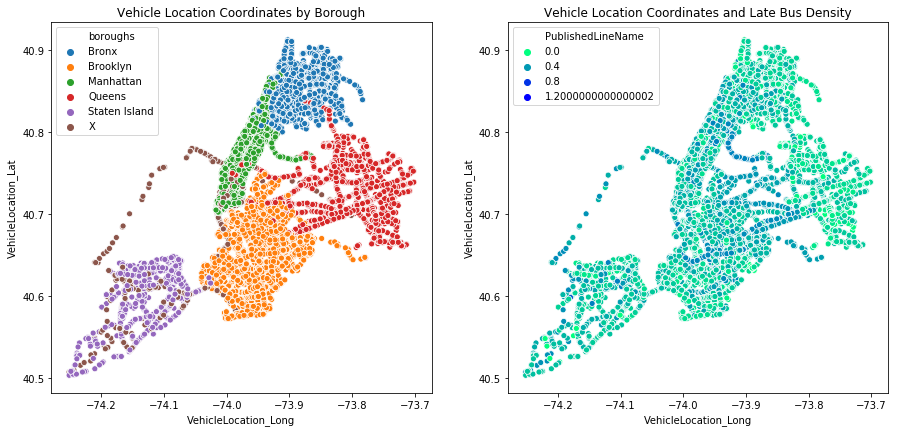

In [71]:
mean_late = mta.PublishedLineName.map(dict(mta.groupby('PublishedLineName').Late_Bus.mean().sort_values(ascending=False)))
plt.figure(figsize=(15,15))
 
plt.subplot(222)
sns.scatterplot(mta.VehicleLocation_Long,mta.VehicleLocation_Lat,hue=mean_late, palette='winter_r')
plt.title('Vehicle Location Coordinates and Late Bus Density')
 
plt.subplot(221)
sns.scatterplot(mta.VehicleLocation_Long,mta.VehicleLocation_Lat,hue=mta.boroughs)
plt.title('Vehicle Location Coordinates by Borough')
plt.show()

Above are scatterplots of the lattitudes and longitudes of the vehicle locations. You can see the shape of New York made from the lats and longs. There doesn't seem to be any points that fall far outside of the area that we are concerned with. The left plot shows the busses grouped by their respective areas of operation and the left highlights the areas where the average number of late busses is the greatest. This may indicate that vehicle location may be a good predictor of whether a bus is going to be late or not. Since there is no meaningful relationship between the raw lattitude and longitude I will create a couple of features to cut down on the dimentionality and well as creating something useful that a model such a Random Forest could use. 

In [72]:
# function to conver lat and long to zip code

def geo_to_zip(lat,long,zip_type):
    from uszipcode import SearchEngine
    from datetime import datetime
    startTime = datetime.now()
     
    search = SearchEngine(simple_zipcode=True)
    mta['col'] = mta[lat].astype(str)+' '+mta[long].astype(str)
    mta[zip_type] = mta['col'].apply(lambda x: search.by_coordinates(float(x.split()[0]),
                                    float(x.split()[1]), radius=10, returns=5)[0].values()[0])
   
    print(datetime.now() - startTime)
    print('done')
    mta.drop('col',1,inplace=True)
geo_to_zip('OriginLat', 'OriginLong','Orig_zip')
geo_to_zip('DestinationLat','DestinationLong','Dest_zip')
geo_to_zip('VehicleLocation_Lat','VehicleLocation_Long','VL_Zip')

0:02:22.569499
done
0:02:32.781764
done
0:02:48.722802
done


In [73]:

# fucntion to convert to compute distance between two points and create a columns of those distances
def distance_between_points(lat1,long1,lat2,long2,to_from):
    import mpu
    from datetime import datetime
    startTime = datetime.now()
    mta['point1'] =mta[lat1].astype(str)+" "+mta[long1].astype(str)
    mta['point2'] = mta[lat2].astype(str)+" "+mta[long2].astype(str)

    mta[to_from] = mta['point1']+" "+mta['point2']
    mta[to_from] = mta[to_from].apply(lambda x : mpu.haversine_distance((float(x.split()[0]), float(x.split()[1])),
                                                                              (float(x.split()[2]), float(x.split()[3]))))
    mta.drop('point1',1,inplace=True)
    mta.drop('point2',1,inplace=True)
    print(datetime.now() - startTime)
    print('done')
    return;


distance_between_points('VehicleLocation_Lat','VehicleLocation_Long','DestinationLat','DestinationLong','VL_to_Dest')
distance_between_points('VehicleLocation_Lat','VehicleLocation_Long','OriginLat', 'OriginLong','VL_to_Origin')
distance_between_points('DestinationLat','DestinationLong','OriginLat', 'OriginLong','Dest_to_Origin') 

0:00:00.156584
done
0:00:00.162606
done
0:00:00.158586
done


In [74]:
# winsorizing the distances to reduce outliers
mta["winVL_to_Dest"]  = winsorize(mta["VL_to_Dest"], (0, .1)) 
mta["winVL_to_Origin"] =winsor_distVL= winsorize(mta["VL_to_Origin"], (0, .1)) 
mta["winDest_to_Origin"] =winsor_distOD= winsorize(mta["Dest_to_Origin"], (0, .1))

In [75]:
#create geohash features from lat and long
import pygeohash as gh
mta['VL_geohash']=mta.apply(lambda x: gh.encode(x.VehicleLocation_Lat, x.VehicleLocation_Long, precision=5), axis=1).astype('category')
mta['O_geohash']=mta.apply(lambda x: gh.encode(x.OriginLat, x.OriginLong, precision=5), axis=1).astype('category')
mta['D_geohash']=mta.apply(lambda x: gh.encode(x.DestinationLat, x.DestinationLong, precision=5), axis=1).astype('category')

In [76]:
mta.head()

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,VehicleLocation_Lat,VehicleLocation_Long,NextStopPointName,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime,Time_delay,Late_Bus,day,hour,minute,weekday,day_of_week,winsor_dist,increased_Late,time_of_day,is_midweek,sin_min,cos_min,sin_hour,cos_hour,sin_day_of_week,cos_day_of_week,rush_hour,boroughs,Orig_zip,Dest_zip,VL_Zip,VL_to_Dest,VL_to_Origin,Dest_to_Origin,winVL_to_Dest,winVL_to_Origin,winDest_to_Origin,VL_geohash,O_geohash,D_geohash
0,2017-06-01 00:03:30,1,X17,E 57 ST/3 AV,40.760429,-73.967674,ARDEN HTS HUGENOT AV via NJ via DRMGOOLE,40.543644,-74.196716,NYCT_2725,40.563053,-74.175912,ARTHUR KILL RD/ANNADALE RD,157.0,2017-06-01 00:03:56,2017-06-01 00:01:32,2.0,0,1,0,1,Thursday,3,157.0,0,night,1,0.104528,0.994522,0.0,1.0,0.433884,-0.900969,0,X,10022,10312,10312,2.783357,28.110445,30.893679,2.783357,9.965182,14.301103,dr5qb,dr5ru,dr5nx
1,2017-06-01 00:13:31,0,Q30,ARCHER AV /SUTPHIN BL,40.700489,-73.807884,LITTLE NECK L NECK PKY,40.764297,-73.725914,NYCT_8443,40.764774,-73.725227,NASSAU BL/LITTLE NECK PY,77.0,2017-06-01 00:13:57,2017-06-01 00:02:00,11.0,1,1,0,2,Thursday,3,77.0,0,night,1,0.207912,0.978148,0.0,1.0,0.433884,-0.900969,0,Queens,11435,11005,11005,0.078491,9.980095,9.901728,0.078491,9.965182,9.901728,dr5xf,dr5x8,dr5xf
2,2017-06-01 00:03:40,1,Bx36,RANDALL AV/OLMSTEAD AV,40.818676,-73.851555,WASHINGTON HTS GW BRIDGE,40.849033,-73.937309,NYCT_281,40.822321,-73.855112,LAFAYETTE AV/PUGSLEY AV,29.0,2017-06-01 00:03:56,2017-06-01 00:02:51,1.0,0,1,0,2,Thursday,3,29.0,0,night,1,0.207912,0.978148,0.0,1.0,0.433884,-0.900969,0,Bronx,10473,10032,10473,7.526045,0.503847,7.965199,7.526045,0.503847,7.965199,dr72p,dr72p,dr72m
3,2017-06-01 00:13:47,0,Q17,MERRICK BL/ARCHER AV,40.704906,-73.793304,FLUSHING MAIN ST STA,40.761745,-73.829529,NYCT_8417,40.740906,-73.787620,HORACE HARDING EXP/185 ST,162.0,2017-06-01 00:14:07,2017-06-01 00:09:53,4.0,0,1,0,9,Thursday,3,162.0,0,night,1,0.809017,0.587785,0.0,1.0,0.433884,-0.900969,0,Queens,11433,11354,11365,4.222787,4.031574,7.018643,4.222787,4.031574,7.018643,dr5xb,dr5x8,dr5rz
4,2017-06-01 00:13:38,0,B38,TILLARY ST/CADMAN PZ E,40.696106,-73.990364,RIDGEWOOD METRO AV,40.713341,-73.914688,NYCT_7228,40.687247,-73.976757,FULTON ST/LAFAYETTE AV,10.0,2017-06-01 00:13:57,2017-06-01 00:14:50,0.0,0,1,0,14,Thursday,3,10.0,0,night,1,0.994522,0.104528,0.0,1.0,0.433884,-0.900969,0,Brooklyn,11201,11237,11217,5.983077,1.512116,6.660744,5.983077,1.512116,6.660744,dr5rk,dr5rs,dr5rw


In [77]:
ffff

NameError: name 'ffff' is not defined

# Preprcessing and Feature Selection

In [92]:

# import need libraries for models
from sklearn.naive_bayes import BernoulliNB 
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn import ensemble 
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report

# fucntion to plot AUC/ROC curve and score
def AUC_ROC_plot(model,X_train,y_train,X_test,y_test,color): 
    model.fit(X_train , y_train)
    y_prob = cross_val_predict(model, X_test, y_test, method='predict_proba',cv=5)    
    auc = roc_auc_score(y_test,y_prob[:,1])
    print('AUC: %.3f' % auc)
    fpr, tpr,thresholds = roc_curve(y_test,y_prob[:,1])
    plt.plot(fpr,tpr,color)    
    plt.plot([0.0,1.0],'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristics')
    plt.xlim([0.0,1.0])     
    plt.ylim([0.0,1.0])
    return;
 
# function to print metrics for comparison 
def Metrics(model, X_train , y_train, X_test, y_test,):
    model.fit(X_train , y_train)
    y_pred = model.predict(X_test) 
    y_prob = cross_val_predict(model, X_test, y_test, method='predict_proba',cv=5)    
    auc = roc_auc_score(y_test,y_prob[:,1])  
   
    print()
    print("Consfusion Matrix")
    print(pd.crosstab(y_test,y_pred))
    print()

    # Classification report
    print("Classification Report")
    from sklearn.metrics import classification_report   
    target_names = ['On-time','Late']
    print(classification_report(y_test,y_pred, target_names=target_names))    
    print("Train Score",model.score(X_train, y_train))
    print("Test Score",model.score(X_test, y_test))
    print("Recall Score",recall_score(y_test,y_pred))
    AUC_ROC_plot(model,X_train,y_train,X_test,y_test,'r')
    plt.show() 
    return;

# the next four fuctions convert features

# convert categorical to target mean in the training set
def cat_to_mean(X_train,X_test,cols=[]):
    X_trainC =  X_train.copy()
    X_testC =  X_test.copy()
    for col in X_trainC[cols]:
        Xmap = dict(X_train.groupby([col]).Late_Bus.mean())
        X_trainC[col] = X_trainC[col].map(Xmap)
        X_testC[col] =X_testC[col].map(Xmap)
        X_trainC.replace([np.inf, -np.inf], 0, inplace=True)
        X_testC.replace([np.inf, -np.inf], 0, inplace=True)
        X_trainC.fillna(0, inplace=True)
        X_testC.fillna(0, inplace=True)     

    return X_trainC, X_testC;

 

# convert categorical feature to the counts in the training set
def cat_to_count(X_train,X_test,cols=[]):
    X_trainC = X_train.copy()
    X_testC =  X_test.copy()
    for col in X_trainC[cols]:
        Xmap = dict(X_trainC[col].value_counts())
        X_trainC[col] = X_trainC[col].map(Xmap)
        X_testC[col] = X_testC[col].map(Xmap)
        X_trainC.replace([np.inf, -np.inf], 0, inplace=True)
        X_testC.replace([np.inf, -np.inf], 0, inplace=True)
        X_trainC.fillna(0, inplace=True)
        X_testC.fillna(0, inplace=True)
 
    return X_trainC, X_testC;

 

In [81]:
mta.columns

Index(['RecordedAtTime', 'DirectionRef', 'PublishedLineName', 'OriginName',
       'OriginLat', 'OriginLong', 'DestinationName', 'DestinationLat',
       'DestinationLong', 'VehicleRef', 'VehicleLocation_Lat',
       'VehicleLocation_Long', 'NextStopPointName', 'DistanceFromStop',
       'ExpectedArrivalTime', 'ScheduledArrivalTime', 'Time_delay', 'Late_Bus',
       'day', 'hour', 'minute', 'weekday', 'day_of_week', 'winsor_dist',
       'increased_Late', 'time_of_day', 'is_midweek', 'sin_min', 'cos_min',
       'sin_hour', 'cos_hour', 'sin_day_of_week', 'cos_day_of_week',
       'rush_hour', 'boroughs', 'Orig_zip', 'Dest_zip', 'VL_Zip', 'VL_to_Dest',
       'VL_to_Origin', 'Dest_to_Origin', 'winVL_to_Dest', 'winVL_to_Origin',
       'winDest_to_Origin', 'VL_geohash', 'O_geohash', 'D_geohash'],
      dtype='object')

In [338]:
mta.select_dtypes('category').describe()

,DirectionRef,PublishedLineName,OriginName,DestinationName,VehicleRef,NextStopPointName,weekday,time_of_day,boroughs,VL_geohash,O_geohash,D_geohash
count,17211,17211,17211,17211,17211,17211,17211,17211,17211,17211,17211,17211
unique,2,236,475,561,4172,5873,7,4,6,69,58,58
top,1,B6,E 126 ST/2 AV,WASHINGTON HTS GW BRIDGE,NYCT_4242,138 ST/37 AV,Thursday,morning,Brooklyn,dr5ru,dr72m,dr72m
freq,8676,325,295,225,14,38,3306,5766,5302,1386,1213,1122


Since the geohashes and the zipcodes contain essentially the same information I am going to drop zipcodes because they have a higher cardinality. I will not be using vehicle reference either since the days and routes the unique busses run are not consistent. All of the other categroical features will be one-hot-encoded except for "NextStopPointName." It has over 5000 levels. I will encode it with the frequency that it occurs in the training set. This way we can still make use of it. 

Some of the other features will be dropped initally because eithere the are redundant or they were used to create the target variable. These features are: 'RecordedAtTime','DistanceFromStop','ExpectedArrivalTime', 'ScheduledArrivalTime', 'Time_delay', 'day', 'hour', 'minute',  'OriginLat', 'OriginLong','VehicleLocation_Lat','VehicleLocation_Long','Orig_zip', 'Dest_zip', 'VL_Zip''OriginName','DestinationName'.

There are some features that may be redundant but I'm not sure which will add more predictive power over the others so they will be left in and eliminated during feature selection.

In [210]:
mta.columns

Index(['RecordedAtTime', 'DirectionRef', 'PublishedLineName', 'OriginName',
       'OriginLat', 'OriginLong', 'DestinationName', 'DestinationLat',
       'DestinationLong', 'VehicleRef', 'VehicleLocation_Lat',
       'VehicleLocation_Long', 'NextStopPointName', 'DistanceFromStop',
       'ExpectedArrivalTime', 'ScheduledArrivalTime', 'Time_delay', 'Late_Bus',
       'day', 'hour', 'minute', 'weekday', 'day_of_week', 'winsor_dist',
       'increased_Late', 'time_of_day', 'is_midweek', 'sin_min', 'cos_min',
       'sin_hour', 'cos_hour', 'sin_day_of_week', 'cos_day_of_week',
       'rush_hour', 'boroughs', 'Orig_zip', 'Dest_zip', 'VL_Zip', 'VL_to_Dest',
       'VL_to_Origin', 'Dest_to_Origin', 'winVL_to_Dest', 'winVL_to_Origin',
       'winDest_to_Origin', 'VL_geohash', 'O_geohash', 'D_geohash'],
      dtype='object')

In [1167]:
modeling_df = mta[['DirectionRef','Late_Bus', 'PublishedLineName',
                   'weekday', 'day_of_week', 'winsor_dist', 'increased_Late',
                   'time_of_day', 'is_midweek', 'sin_hour', 'cos_hour', 'sin_day_of_week', 'cos_day_of_week',
                    'rush_hour',  'winVL_to_Dest', 'winVL_to_Origin','NextStopPointName',
                   'winDest_to_Origin','VL_geohash', 'O_geohash', 'D_geohash']]

dummies = ['time_of_day', 'VL_geohash', 'O_geohash', 'D_geohash','PublishedLineName',
         'weekday']

 
counts = ['NextStopPointName']
# one-hot-encoding using pandas get_dummies 
modeling_df = pd.concat([modeling_df.drop(dummies,1), pd.get_dummies(modeling_df[dummies],drop_first=True)], axis=1)
 
X  = modeling_df
Y = modeling_df.Late_Bus

# split the data 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2, random_state=20)  

In [1168]:
# count transformation 
X_train, X_test  = cat_to_count(X_train,X_test,counts)
X_train.sample(frac=.001)[:10]

,DirectionRef,Late_Bus,day_of_week,winsor_dist,increased_Late,is_midweek,sin_hour,cos_hour,sin_day_of_week,cos_day_of_week,rush_hour,winVL_to_Dest,winVL_to_Origin,NextStopPointName,winDest_to_Origin,time_of_day_evening,time_of_day_morning,time_of_day_night,VL_geohash_dr5nr,VL_geohash_dr5nw,VL_geohash_dr5nx,VL_geohash_dr5nz,VL_geohash_dr5pp,VL_geohash_dr5pr,VL_geohash_dr5q8,...,PublishedLineName_X21,PublishedLineName_X22,PublishedLineName_X22A,PublishedLineName_X27,PublishedLineName_X28,PublishedLineName_X3,PublishedLineName_X30,PublishedLineName_X31,PublishedLineName_X37,PublishedLineName_X38,PublishedLineName_X4,PublishedLineName_X42,PublishedLineName_X5,PublishedLineName_X63,PublishedLineName_X64,PublishedLineName_X68,PublishedLineName_X7,PublishedLineName_X8,PublishedLineName_X9,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
3537,0,0,2,16.0,0,1,0.965926,-2.588190e-01,0.974928,-0.222521,1,4.854115,5.468286,2,10.166018,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
16767,0,0,4,207.0,1,0,0.707107,-7.071068e-01,-0.433884,-0.900969,1,4.285404,6.938700,8,11.155060,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15176,0,0,1,2.0,1,0,-0.866025,-5.000000e-01,0.781831,0.623490,1,8.028546,4.857309,4,12.842332,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2338,1,0,0,71.0,1,1,0.500000,-8.660254e-01,0.000000,1.000000,0,0.779834,6.979174,3,7.751509,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
15406,0,0,2,385.0,0,0,1.000000,6.123234e-17,0.974928,-0.222521,1,5.541241,9.965182,10,14.301103,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5520,0,1,5,0.0,1,1,-0.258819,-9.659258e-01,-0.974928,-0.222521,0,2.901516,5.895753,1,7.077266,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
12739,0,0,3,13.0,0,0,-0.258819,9.659258e-01,0.433884,-0.900969,0,3.817435,9.965182,3,14.301103,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
12305,0,0,3,301.0,1,0,0.500000,-8.660254e-01,0.433884,-0.900969,0,0.299681,7.202085,7,7.369219,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
5545,1,0,5,6.0,1,1,-0.500000,-8.660254e-01,-0.974928,-0.222521,0,5.305850,2.467814,11,7.772842,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
6891,1,0,1,114.0,0,0,0.965926,-2.588190e-01,0.781831,0.623490,1,1.449054,4.795347,17,6.197454,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


Next we'll take at a look at the correlations of the variables to the target. And start cutting down some of the dimentionality.

In [1169]:
# find correlations to target
corr_matrix = X_train.corr().abs()
corr_to_target = corr_matrix['Late_Bus'].sort_values(ascending=False)

In [1170]:
# top 30 features with the highest correlations to target
corr_to_target[:30]

Late_Bus                     1.000000
winVL_to_Origin              0.210330
sin_hour                     0.179964
time_of_day_morning          0.143644
winVL_to_Dest                0.138866
time_of_day_evening          0.109833
increased_Late               0.096487
winDest_to_Origin            0.086794
NextStopPointName            0.084176
day_of_week                  0.069169
weekday_Monday               0.067995
PublishedLineName_B41        0.057084
PublishedLineName_B35        0.054593
D_geohash_dr5rq              0.048993
PublishedLineName_M60-SBS    0.047252
VL_geohash_dr5x9             0.043060
D_geohash_dr72w              0.042191
O_geohash_dr5rs              0.041755
VL_geohash_dr72j             0.041190
O_geohash_dr5rt              0.040672
D_geohash_dr5r4              0.039944
PublishedLineName_B12        0.039506
cos_day_of_week              0.037012
D_geohash_dr72j              0.036955
PublishedLineName_B25        0.036143
VL_geohash_dr5xb             0.036076
PublishedLin

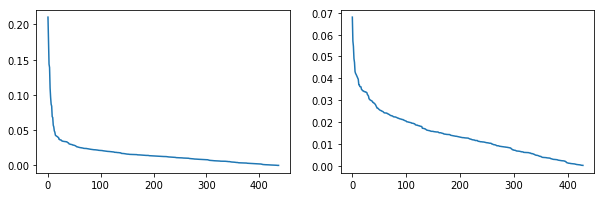

In [1171]:
plt.figure(figsize=(10,3))
plt.subplot(121)
plt.plot(corr_to_target.values[1:])
plt.subplot(122)
plt.plot(corr_to_target.values[10:])
plt.show()

The correlation to target drops off pretty steep at around 25 features. But the first 10 features are numerical features and the rest are the dummies. On the left if we look at just the dummies variables then we can see that the elbow doesnt make a turn until between 150 and 200 features. This is were I will minimize the feature set to. 
Well start with order the features by their correlation to the target and the use sklearn's recursive feature selction tool.

In [1172]:
#drop correlations that were nan and order feature columns from decending correlation scores
corr_to_target = dict(corr_to_target[:-1])  
X_train = X_train.loc[:,corr_to_target.keys()]
X_test = X_test.loc[:,corr_to_target.keys()]

In [1173]:
# drop the target from independent features
X_train.drop('Late_Bus',1,inplace=True)
X_test.drop('Late_Bus',1,inplace=True)

In [1174]:
# recusive feature selection using logistic regression 
lr = LogisticRegression(max_iter=300, solver= 'liblinear', warm_start= True)

from sklearn.feature_selection import RFE
# feature extraction
rfe = RFE(lr, n_features_to_select=150)
# fit on train set
fit = rfe.fit(X_train, y_train)
# transform train set
recursive_features = fit.transform(X_train)
 

In [1175]:
X_train = X_train.iloc[:,pd.DataFrame(recursive_features).columns] 
X_test = X_test.iloc[:,pd.DataFrame(recursive_features).columns] 

In [1176]:
X_train.shape

(13768, 150)

Next I'll take a look at the heatmap of the correlation matrix to see if any features are highly correlated. If so Well drop one of the correlated features and keep the one that is most highly correlated with the target.

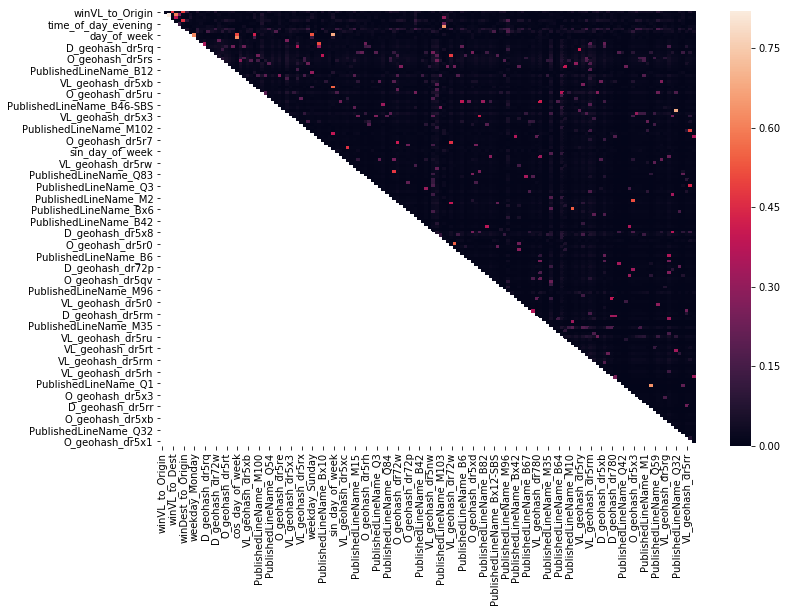

In [1177]:
corr_matrix = X_train.corr().abs().where(np.triu(np.ones(X_train.corr().abs().shape), k=1).astype(np.bool))
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix,annot=False)
plt.show()

In [1178]:
to_drop = [column for column in corr_matrix.columns if any(corr_matrix[column] > 0.50)]
print('Columns to drop: ' , (len(to_drop)))
to_drop

Columns to drop:  13


['time_of_day_morning',
 'time_of_day_evening',
 'weekday_Monday',
 'cos_day_of_week',
 'weekday_Sunday',
 'O_geohash_dr5r7',
 'sin_day_of_week',
 'time_of_day_night',
 'PublishedLineName_S48',
 'D_geohash_dr72n',
 'O_geohash_dr5x3',
 'D_geohash_dr5x9',
 'PublishedLineName_Q32']

In [1179]:
# Drop one of each pair of correlated features
X_train.drop(to_drop,1,inplace=True)
X_test.drop(to_drop,1,inplace=True)


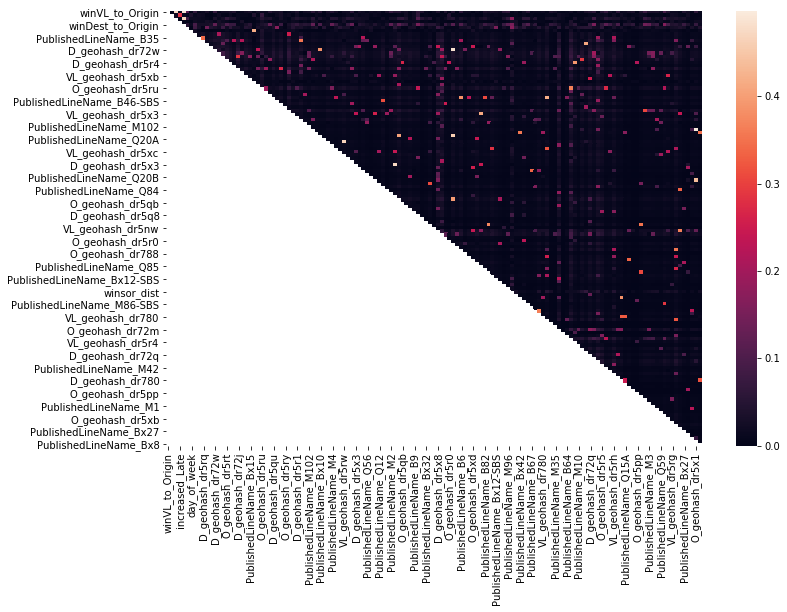

In [1180]:
corr_matrix = X_train.corr().abs().where(np.triu(np.ones(X_train.corr().abs().shape), k=1).astype(np.bool))
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix,annot=False)
plt.show()

In [1181]:
print(X_train.shape) 
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(13768, 137)
(13768,)
(3443, 137)
(3443,)


Since the we are dealing with and imbalanced dataset I'll use a random oversampler function to create more random instances of the minority class to balance the training set only.

In [1185]:
import imblearn
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=20)
X_trainB, y_trainB = ros.fit_sample(X_train, y_train)

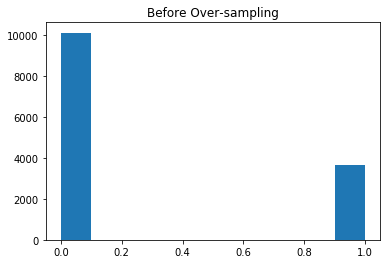

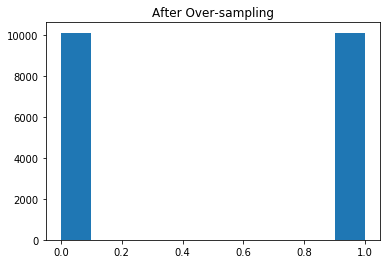

In [1190]:
plt.hist(y_train)
plt.title('Before Over-sampling')
plt.show()
plt.hist(y_trainB)
plt.title('After Over-sampling')
plt.show()

In [1144]:
# scale the data
from sklearn.preprocessing import StandardScaler
sclr = StandardScaler()
sclr.fit(X_trainB)
X_trainS = sclr.transform(X_trainB)
X_testS = sclr.transform(X_test)


# Modeling

### Random Forest and Gradient Boost algorithms.

Random_Forest


Consfusion Matrix
col_0        0    1
Late_Bus           
0         2200  314
1          629  300

Classification Report
              precision    recall  f1-score   support

     On-time       0.78      0.88      0.82      2514
        Late       0.49      0.32      0.39       929

    accuracy                           0.73      3443
   macro avg       0.63      0.60      0.61      3443
weighted avg       0.70      0.73      0.71      3443

Train Score 0.996785996835443
Test Score 0.7261109497531223
Recall Score 0.32292787944025836
AUC: 0.655


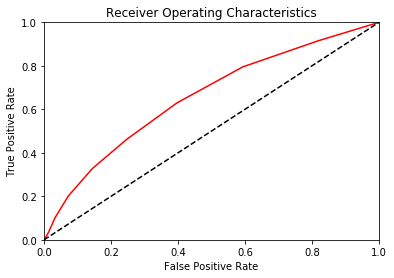

0:00:00
Gradient_Boost


Consfusion Matrix
col_0        0    1
Late_Bus           
0         1713  801
1          321  608

Classification Report
              precision    recall  f1-score   support

     On-time       0.84      0.68      0.75      2514
        Late       0.43      0.65      0.52       929

    accuracy                           0.67      3443
   macro avg       0.64      0.67      0.64      3443
weighted avg       0.73      0.67      0.69      3443

Train Score 0.7006526898734177
Test Score 0.6741214057507987
Recall Score 0.6544671689989235
AUC: 0.706


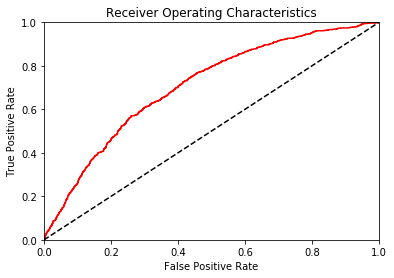

0:00:00


In [1191]:
# run
models = []  
models.append(('Random_Forest' , ensemble.RandomForestClassifier(n_estimators=10,class_weight='balanced',random_state=20)))  

models.append(('Gradient_Boost' , ensemble.GradientBoostingClassifier()))
 
 
 
for name ,model in models:
    
    print(str(name))
    print()
    startTime = datetime.now()  
 
    Metrics(model, X_trainS , y_trainB, X_testS, y_test)
    startTime = datetime.now()  
    print(datetime.now() - startTime)

Initally there is overfitting on both models. The AUC scores aren't terrible but the Random Forest is not picking up very many late busses. Possibly tuning the hyperparameter can fix some of these issues.

### Logistic regression alogrithim.

Logistic Regression


Consfusion Matrix
col_0        0    1
Late_Bus           
0         1713  801
1          318  611

Classification Report
              precision    recall  f1-score   support

     On-time       0.84      0.68      0.75      2514
        Late       0.43      0.66      0.52       929

    accuracy                           0.67      3443
   macro avg       0.64      0.67      0.64      3443
weighted avg       0.73      0.67      0.69      3443

Train Score 0.6791930379746836
Test Score 0.6749927388905025
Recall Score 0.6576964477933261
AUC: 0.696


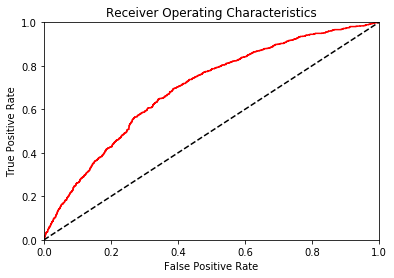

0:00:00


In [1146]:
lr = LogisticRegression( solver='liblinear',class_weight='balanced')
AUCscore = {}
Recallscore = {}
 
print('Logistic Regression')
print()
startTime = datetime.now()  

Metrics(lr, X_trainS , y_trainB, X_testS, y_test) 

In [1010]:
print(cross_val_score(lr, X_train, y_train, cv=10))

[0.65021771 0.65457184 0.68627451 0.65649964 0.68119099 0.68336964
 0.65116279 0.67587209 0.66860465 0.67151163]


The first run looks pretty good. The score is still low but it is consistent in the training set, test set and cross validataion. I'll print the first 20 coefficients 

### Tuning hyperparameters using GridsearchCV

In [1196]:
# initiate GridsearchCV for best parameters
from sklearn.model_selection import GridSearchCV
def gridsearch(model, X_trainS , y_trainB, param_grid):    
    grid = GridSearchCV(model, param_grid, cv=3, scoring='roc_auc', return_train_score=True,verbose=1)
    grid.fit(X_trainS , y_trainB)
    print(grid.best_params_)
    print(grid.best_score_)

# random forest classifier
rfc =  ensemble.RandomForestClassifier(n_estimators=10,random_state=20,warm_start=True)   

# parameters to search
param_grid = { 'n_estimators': range(2,30),'max_depth' : range(1,10),'max_leaf_nodes':range(2,10,1)}
# gridsearch
gridsearch(rfc, X_train , y_train, param_grid)

Fitting 3 folds for each of 2016 candidates, totalling 6048 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'max_depth': 8, 'max_leaf_nodes': 9, 'n_estimators': 28}
0.7032627173628195


[Parallel(n_jobs=1)]: Done 6048 out of 6048 | elapsed:  9.4min finished


Random Forest

Consfusion Matrix
col_0        0    1
Late_Bus           
0         1642  872
1          320  609

Classification Report
              precision    recall  f1-score   support

     On-time       0.84      0.65      0.73      2514
        Late       0.41      0.66      0.51       929

    accuracy                           0.65      3443
   macro avg       0.62      0.65      0.62      3443
weighted avg       0.72      0.65      0.67      3443

Train Score 0.6588212025316456
Test Score 0.6537902991577113
Recall Score 0.6555435952637244
AUC: 0.691


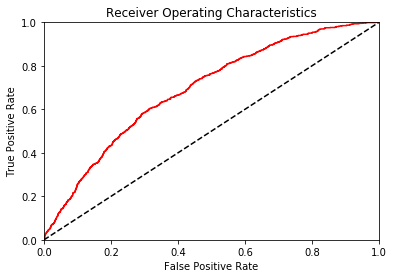

Cross validataion score: [0.7394775  0.75471698 0.7480029  0.73783588 0.75744372 0.75018155
 0.7434593  0.74854651 0.74055233 0.75799419]


In [1198]:
# run classifer with new params
print('Random Forest')
rfc = ensemble.RandomForestClassifier(max_features='auto',max_depth=8, max_leaf_nodes=9,n_estimators=28,class_weight='balanced',random_state=20)
Metrics(rfc, X_trainS , y_trainB, X_testS, y_test)
print('Cross validataion scores:',cross_val_score(lr, X_train, y_train, cv=10))

No more over fitting and the algorithim is picking up more of the late busses!! Let's take a look at the feature importances.

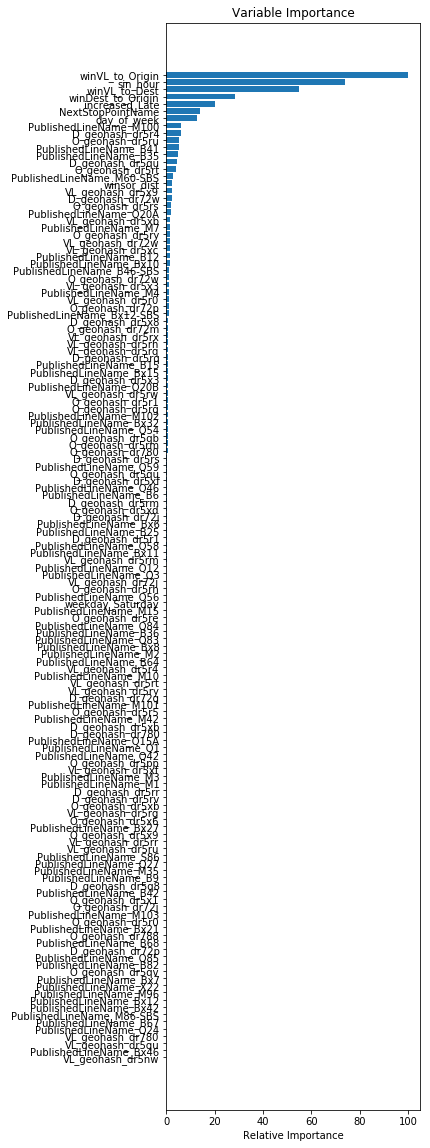

In [1208]:
#plot feature importances
feature_importance = rfc.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(10,20))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

It looks like I could have left out more features in the selection process, however since there hasn't been any modeling of this data set online so there is no benchmark to compare the scores so I'll take no more action and leave it as it is. I'll move on to the other tune the other models.

In [ ]:
clf  = ensemble.GradientBoostingClassifier()
param_grid = { 'n_estimators': range(2,30),'max_depth' : range(1,10),'max_leaf_nodes':range(2,10,1)}
gridsearch(clf, X_trainS , y_trainB, param_grid)

In [ ]:
# run classifer with new params
print('Random Forest')
rfc = ensemble.RandomForestClassifier(max_features='auto',max_depth=8, max_leaf_nodes=9,n_estimators=28,class_weight='balanced',random_state=20)
Metrics(rfc, X_trainS , y_trainB, X_testS, y_test)
print('Cross validataion score:',cross_val_score(lr, X_train, y_train, cv=10))

In [1222]:
param_grid = param_grid = {'solver':['sag', 'liblinear'],'max_iter':range(200,1000,75),  'warm_start' :[True]}
gridsearch(lr, X_trainS , y_trainB, param_grid)

Fitting 3 folds for each of 22 candidates, totalling 66 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\keith\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\keith\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\keith\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\keith\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

{'max_iter': 200, 'solver': 'liblinear', 'warm_start': True}
0.7340409295171596


Logistic Regression

Consfusion Matrix
col_0        0    1
Late_Bus           
0         1713  801
1          318  611

Classification Report
              precision    recall  f1-score   support

     On-time       0.84      0.68      0.75      2514
        Late       0.43      0.66      0.52       929

    accuracy                           0.67      3443
   macro avg       0.64      0.67      0.64      3443
weighted avg       0.73      0.67      0.69      3443

Train Score 0.6791930379746836
Test Score 0.6749927388905025
Recall Score 0.6576964477933261
AUC: 0.695


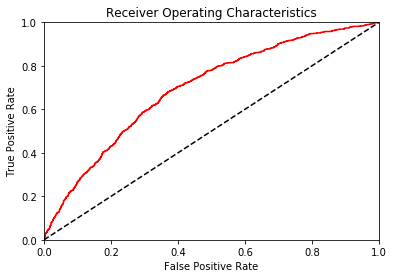

Cross validataion score: [0.7394775  0.75471698 0.7480029  0.73783588 0.75744372 0.75018155
 0.7434593  0.74854651 0.74055233 0.75799419]


In [1223]:
print('Logistic Regression')
lr = LogisticRegression(max_iter=200,solver= 'liblinear', warm_start= True)
lr.fit(X_trainS, y_trainB) 
Metrics(lr, X_trainS , y_trainB, X_testS, y_test)
print('Cross validataion score:',cross_val_score(lr, X_train, y_train, cv=10))

In [1228]:
LR_coeff_df = { 'Features': X_train.columns,'Coefficients': lr.coef_[0]}
LR_coeff_df = pd.DataFrame(data=LR_coeff_df)
print('First 15 Coefficients')
LR_coeff_df.sort_values(by='Coefficients',ascending=False)[:15]

First 15 Coefficients


,Features,Coefficients
0,winVL_to_Origin,0.271799
6,day_of_week,0.171519
4,winDest_to_Origin,0.164839
3,increased_Late,0.157205
5,NextStopPointName,0.141745
101,PublishedLineName_S86,0.122108
10,PublishedLineName_M60-SBS,0.120761
30,O_geohash_dr5ry,0.112870
17,PublishedLineName_B12,0.104729
33,D_geohash_dr5r1,0.095085


In [ ]:
param_grid ={'loss':['deviance', 'exponential'], 'n_estimators': [200, 500],'max_features': ['auto', 'sqrt'],
             'max_depth':range(2,12,1)}
clf = ensemble.GradientBoostingClassifier(warm_start=True)
gridsearch(clf, X_trainS , y_trainB, param_grid)

Fitting 3 folds for each of 80 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [ ]:
models = [] 
 
models.append(('Random_Forest' , ensemble.RandomForestClassifier(max_features='auto',max_depth=8,n_estimators=500,class_weight='balanced',random_state=20)))  

models.append(('Gradient_Boost' , ensemble.GradientBoostingClassifier(max_features='auto',max_depth=8,n_estimators=500,random_state=20)))
 
 
 
for name ,model in models:
    
    print(str(name))
    print()
    startTime = datetime.now()  
 
    Metrics(model, X_trainS , y_trainB, X_testS, y_test)
    startTime = datetime.now()  
    print(datetime.now() - startTime)

In [ ]:
feature_importance = model.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(10,20))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

### LASSO

# DONT TOUCH!!

In [ ]:



modeling_df = mta[[  'DirectionRef', 'PublishedLineName', 'OriginName',
        'DestinationName',   
        'NextStopPointName','Late_Bus', 'VehicleRef',
        'weekday', 'day_of_week', 'winsor_dist',
       'increased_Late', 'time_of_day', 'is_midweek', 'sin_min', 'cos_min',
       'sin_hour', 'cos_hour', 'sin_day_of_week', 'cos_day_of_week',
       'boroughs', 'rush_hour', 'Orig_zip', 'Dest_zip', 'VL_Zip', 'winVL_to_Dest', 'winVL_to_Origin',
       'winDest_to_Origin', 'VL_geohash', 'O_geohash', 'D_geohash',
        ]]
#modeling_df = mta[['Late_Bus','PublishedLineName']]

dummies = ['PublishedLineName',  'time_of_day','OriginName',  'DestinationName','VL_geohash', 'O_geohash', 'D_geohash',
         'weekday', 'boroughs', 'Orig_zip', 'Dest_zip', 'VL_Zip']
#dummies = ['PublishedLineName']
counts = ['NextStopPointName', 'VehicleRef' ]

modeling_df = pd.concat([modeling_df.drop(dummies,1), pd.get_dummies(modeling_df[dummies],drop_first=True)], axis=1)
 
X  = modeling_df
Y = modeling_df.Late_Bus


 

 
# split the data 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2, random_state=20)  
# count encoding 
X_train, X_test = cat_to_count(X_train,X_test,counts) 

X_train.drop('Late_Bus',1,inplace=True)
X_test.drop('Late_Bus',1,inplace=True)

# balance class
import imblearn
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=20)
X_trainB, y_trainB = ros.fit_sample(X_train, y_train)
 


# scale
from sklearn.preprocessing import StandardScaler
sclr = StandardScaler()
sclr.fit(X_trainB)
X_trainS = sclr.transform(X_trainB)
X_testS = sclr.transform(X_test)
 

Train_Score =  []
Test_Score =  []
Recall_Score =  []
ii = []



In [ ]:
modeling_df = mta[[  'DirectionRef',  
        'Late_Bus', 
        'weekday', 'day_of_week', 'winsor_dist',
       'increased_Late', 'time_of_day', 'is_midweek', 
       'sin_hour', 'cos_hour', 'sin_day_of_week', 'cos_day_of_week',
       'boroughs', 'rush_hour',  'winVL_to_Dest', 'winVL_to_Origin',
       'winDest_to_Origin', 'VL_geohash', 'O_geohash', 'D_geohash',
        ]]
#modeling_df = mta[['Late_Bus','PublishedLineName']]

#dummies = ['PublishedLineName',  'time_of_day','OriginName',  'DestinationName','VL_geohash', 'O_geohash', 'D_geohash',
 #        'weekday', 'boroughs', 'Orig_zip', 'Dest_zip', 'VL_Zip']
#dummies = ['PublishedLineName']
dummies = [   'time_of_day',    'VL_geohash', 'O_geohash', 'D_geohash',
         'weekday', 'boroughs', ]
counts = []
modeling_df = pd.concat([modeling_df.drop(dummies,1), pd.get_dummies(modeling_df[dummies],drop_first=True)], axis=1)
 
X  = modeling_df
Y = modeling_df.Late_Bus


 

 
# split the data 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2, random_state=20)  
# count encoding 
X_train, X_test = cat_to_count(X_train,X_test,counts) 

X_train.drop('Late_Bus',1,inplace=True)
X_test.drop('Late_Bus',1,inplace=True)
X_train.drop(a,1,inplace=True)
X_test.drop(a,1,inplace=True)



# balance class
import imblearn
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=20)
X_trainB, y_trainB = ros.fit_sample(X_train, y_train)
 


# scale
from sklearn.preprocessing import StandardScaler
sclr = StandardScaler()
sclr.fit(X_trainB)
X_trainS = sclr.transform(X_trainB)
X_testS = sclr.transform(X_test)
 

Train_Score =  []
Test_Score =  []
Recall_Score =  []
ii = []


In [329]:
 
            
lr = LogisticRegression(penalty='l1',solver='liblinear',max_iter=50,C=.0038, warm_start=True)
lr.fit(X_trainS, y_trainB)
y_pred = lr.predict(X_testS) 
print("Train Score",lr.score(X_trainS, y_trainB))
print("Test Score",lr.score(X_testS, y_test))
print("Recall Score",recall_score(y_test,y_pred))
print(i)
#Train_Score.append(lr.score(X_trainS, y_trainB))
#Test_Score.append(lr.score(X_testS, y_test))
#Recall_Score.append(recall_score(y_test,y_pred))
#ii.append(i)
print()
#Metrics(lr, X_trainS , y_trainB, X_testS, y_test)

Train Score 0.6473496835443038
Test Score 0.6561138541969213
Recall Score 0.6458557588805167
5



In [ ]:
plt.plot(ii,Train_Score) 
plt.plot(ii,Test_Score)
plt.plot(ii,Recall_Score)

In [ ]:
print('LASSO Logistic Regression')
%timeit lr = LogisticRegression(penalty='l1',solver='liblinear',max_iter=20,C=.004, warm_start=True)
Metrics(lr, X_trainS , y_trainB, X_testS, y_test)

In [ ]:
d = { 'Features': X_train.columns,'Coefficients': lr.coef_[0]}
df = pd.DataFrame(data=d)
df.sort_values(by='Coefficients',ascending=False)
a = df[df.Coefficients==0] 
a

### PCA

In [ ]:
modeling_df = mta[['Late_Bus','DirectionRef', 'PublishedLineName', 'OriginName','DestinationName',           
                   'NextStopPointName','VehicleRef','weekday', 'day_of_week', 'winsor_dist',
                   'increased_Late', 'time_of_day', 'is_midweek', 'sin_min', 'cos_min',
                   'sin_hour', 'cos_hour', 'sin_day_of_week', 'cos_day_of_week','boroughs', 
                   'rush_hour', 'Orig_zip', 'Dest_zip', 'VL_Zip', 'winVL_to_Dest', 'winVL_to_Origin',
                   'winDest_to_Origin', 'VL_geohash', 'O_geohash', 'D_geohash',
                  ]]

dummies = ['PublishedLineName',  'time_of_day','OriginName',  'DestinationName','VL_geohash', 'O_geohash', 'D_geohash',
           'weekday', 'boroughs', 'Orig_zip', 'Dest_zip', 'VL_Zip', ]

counts = ['NextStopPointName','VehicleRef']

modeling_df = pd.concat([modeling_df.drop(dummies,1), pd.get_dummies(modeling_df[dummies],drop_first=True)], axis=1)
 
X  = modeling_df.drop('Late_Bus',1)
Y = modeling_df.Late_Bus
 

# split the data 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2, random_state=20)  

In [ ]:
# convert to counts 
X_train, X_test = cat_to_count(X_train,X_test,counts) 

In [ ]:
X_train.shape

In [ ]:
#Random over_sample
ros = RandomOverSampler(random_state=20)
X_trainB, y_trainB = ros.fit_sample(X_train, y_train)


In [ ]:
# scale
from sklearn.preprocessing import StandardScaler
sclr = StandardScaler()
sclr.fit(X_trainB)
X_trainS = sclr.transform(X_trainB)
X_testS = sclr.transform(X_test)

from sklearn.preprocessing import normalize
X_trainS = normalize(X_trainS)
X_testS = normalize(X_testS)


In [ ]:
#pca
pca = PCA(n_components=,random_state=20)
pca.fit(X_trainS)  
X_train = pca.fit_transform(X_trainS)
X_test = pca.transform(X_testS)

In [ ]:
 
variance = pca.explained_variance_ratio_ #calculate variance ratios

var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
var #cumulative sum of variance explained with [n] features

In [ ]:
a = pca.singular_values_
 

In [ ]:
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.ylim(30,100.5)
plt.style.context('seaborn-whitegrid')
plt.plot(var)

In [ ]:
models = []

 
models.append(('Random_Forest' , ensemble.RandomForestClassifier(max_features= 'auto',criterion='gini', max_depth=10,n_estimators=500,
                                                                  class_weight='balanced',random_state=20)))
startTime = datetime.now()
models.append(('Logistic_Regression' , LogisticRegression(solver='lbfgs',max_iter=300)))
 
models.append(('Gradient_Boost' , ensemble.GradientBoostingClassifier(n_estimators=300,random_state=20)))
 
AUCscore = {}
Recallscore = {}
 
for name ,model in models:    
    print(str(name))
    print()
    Metrics(model, X_train , y_trainB, X_test, y_test)
    

In [ ]:
# initiate GridsearchCV for best parameters
from sklearn.model_selection import GridSearchCV
def gridsearch(model, X_train , y_train, param_grid):    
    grid = GridSearchCV(model, param_grid, cv=3, scoring='roc_auc', return_train_score=True,verbose=.5)
    grid.fit(X_train , y_train)
    print(grid.best_params_)
    print(grid.best_score_)
    
    
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
 gridsearch(model, X_train , y_train, param_grid)

In [ ]:
#complexity vs error

train = []
test = []
ii = []


for n in np.arange(1,20,1):

    import sklearn.feature_selection 
    select =sklearn.feature_selection.SelectKBest(k=n)
    selected_features = select.fit(X_train, y_train)
    indicies_selected = selected_features.get_support(indices=True)
    colnames_selected = [X_train.columns[i] for i in indicies_selected]
    X_selected = X_train[colnames_selected]
    print(colnames_selected)
    #X = X[colnames_selected]
    #X = X[colnames_selected]

    X_trainc = X_train[colnames_selected]
    X_testc = X_test[colnames_selected]
    
    import imblearn
    from imblearn.over_sampling import RandomOverSampler
    ros = RandomOverSampler(random_state=20)
    X_trainc, y_trainc = ros.fit_sample(X_trainc, y_train)

    
    
    from sklearn.preprocessing import StandardScaler
    sclr = StandardScaler()
    sclr.fit(X_trainc)
    X_trainc = sclr.transform(X_trainc)
    X_testc = sclr.transform(X_testc)
 

    
    model = LogisticRegression(penalty='l1',solver='liblinear',max_iter=500,C=1)
    model.fit(X_trainc , y_trainc)
    print(str(name))
    print()
    y_pred = model.predict(X_testc) 
    y_prob = cross_val_predict(model, X_testc, y_test, method='predict_proba',cv=5)    
    print(roc_auc_score(y_test,y_prob[:,1])) 
    print("Train Score",model.score(X_trainc, y_trainc))
    print("Test Score",model.score(X_testc, y_test))
    train.append(model.score(X_trainc, y_trainc))
    test.append(model.score(X_testc, y_test))
    ii.append(n)
plt.plot(train)
plt.plot(test)

In [ ]:
mta.Dest_to_Origin

In [ ]:
#opimized




modeling_df = mta[[  'DirectionRef', 'PublishedLineName', 'OriginName',
        'DestinationName',   
        'NextStopPointName','Late_Bus',
        
        'weekday', 'day_of_week', 'winsor_dist',
       'increased_Late', 'time_of_day', 'is_midweek', 'sin_min', 'cos_min',
       'sin_hour', 'cos_hour', 'sin_day_of_week', 'cos_day_of_week',
       'boroughs', 'rush_hour', 'Orig_zip', 'Dest_zip', 'VL_Zip', 'winVL_to_Dest', 'winVL_to_Origin',
       'winDest_to_Origin', 'VL_geohash', 'O_geohash', 'D_geohash',
        ]]
modeling_df = mta[['Late_Bus','PublishedLineName']]

dummies = ['PublishedLineName',  'time_of_day','OriginName',  'DestinationName','VL_geohash', 'O_geohash', 'D_geohash',
         'weekday', 'boroughs', 'Orig_zip', 'Dest_zip', 'VL_Zip', 'NextStopPointName']
dummies = ['PublishedLineName']
counts = ['NextStopPointName','VehicleRef']

modeling_df = pd.concat([modeling_df.drop(dummies,1), pd.get_dummies(modeling_df[dummies],drop_first=True)], axis=1)
 
X  = modeling_df
Y = modeling_df.Late_Bus

### Conclusion

The 


There are several limitations with the model that should be considered. The first being that the dataset was only from one month, June. Although, there were six million observations they only tell us about the month of June. It would be better to have samples from every month of the year. This way we could look annual patterns such as seasonal traffic and weather. Another imitation is that, because of time, there wasn't much spent on reseaching patterns that effect traffic or into what actually causes a bus to be late in the first place(it may not always be traffic). There is also the matter of the limitations of my local machine to run the algorithms. I would have liked to have used all of the data if I could have. 

